# Figure 4

# Loading the data

Here we load all the packages that we need, and import the data (loom files, from the preprocessing notebook).

## Loading packages

In [1]:
#Import packages.  Put plots "inline" in the notebook.  

import numpy as np  # For numerical computations.
import pandas as pd  # Pandas for data analysis.
from IPython.display import display # Pretty display of data frames.

# Plotting
import matplotlib.pyplot as plt  # For basic plotting.
import matplotlib.transforms as transforms
import matplotlib.colors as pcolors
from matplotlib.patches import Rectangle
plt.rcParams['svg.fonttype'] = 'none' # Export fonts as text, not as curves.
import seaborn as sns # For pretty visualization in Seaborn.  See https://seaborn.pydata.org/

# Stats and scipy
import statsmodels.api as sm
import scipy.stats as ss
import scipy.cluster.hierarchy as sch # For hierarchical clustering.


from bisect import bisect # See bisect.bisect.
from itertools import compress # Nice way to apply masks to lists, etc.

# Import from scikit, for machine learning.

from sklearn import base
from sklearn.preprocessing import Binarizer, MinMaxScaler
from sklearn.model_selection import ShuffleSplit, train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import BernoulliNB, GaussianNB # Naive Bayes Classifiers.
from sklearn.ensemble import VotingClassifier # Voting classifier.
from sklearn.svm import LinearSVC, NuSVC, SVC # Support Vector Machine 
from sklearn.pipeline import make_pipeline, Pipeline 
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
# UMAPs are all the rage... no more tSNE. Sad :(
import umap

import scanpy as sc
sc.settings.verbosity = 1             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

import anndata

# Put plots inline rather than in a pop-up.
%matplotlib inline

scanpy==1.7.1 anndata==0.7.6 umap==0.5.1 numpy==1.20.1 scipy==1.6.1 pandas==1.2.3 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.8.3 louvain==0.7.0 leidenalg==0.8.3


In [2]:
def hrule(repchar = '=', length=80):
    '''
    A quick function to print a horizontal line.
    '''
    if len(repchar) == 1:
        print(repchar*length)

In [3]:
def setfontsize():
    SMALL_SIZE = 6
    MEDIUM_SIZE = 6
    BIGGER_SIZE = 6

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    
    plt.rcParams['font.sans-serif'] = 'Helvetica'

    plt.rcParams['svg.fonttype'] = 'none' # Export fonts as text, not as curves.

    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['ps.fonttype'] = 42

In [4]:
def desetfontsize():
    SMALL_SIZE = 10
    MEDIUM_SIZE = 12
    BIGGER_SIZE = 14

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [5]:
plt.rcParams['font.sans-serif'] = 'Helvetica'
from matplotlib.font_manager import findfont, FontProperties
font = findfont(FontProperties(family=['sans-serif']))
font

'/System/Library/Fonts/Helvetica.ttc'

Check figure below to see that Helvetica is being used.

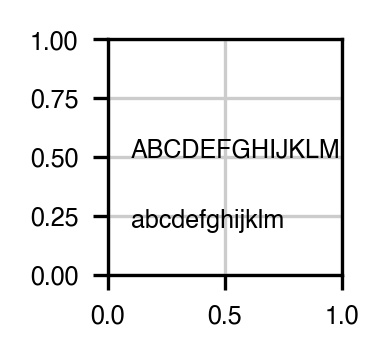

In [6]:
setfontsize()
fig,ax = plt.subplots(1,1,figsize=(1,1), dpi=300)
ax.text(0.1,0.5,'ABCDEFGHIJKLM')
ax.text(0.1,0.2, 'abcdefghijklm')
plt.show()

In [7]:
from matplotlib.image import imread
from tempfile import NamedTemporaryFile

def get_size(fig, dpi=300):
    with NamedTemporaryFile(suffix='.png') as f:
        fig.savefig(f.name, bbox_inches='tight', dpi=dpi)
        height, width, _channels = imread(f.name).shape
        return width / dpi, height / dpi

def set_size(fig, size, dpi=300, eps=1e-2, give_up=2, min_size_px=10):
    target_width, target_height = size
    set_width, set_height = target_width, target_height # reasonable starting point
    deltas = [] # how far we have
    while True:
        fig.set_size_inches([set_width, set_height])
        actual_width, actual_height = get_size(fig, dpi=dpi)
        set_width *= target_width / actual_width
        set_height *= target_height / actual_height
        deltas.append(abs(actual_width - target_width) + abs(actual_height - target_height))
        if deltas[-1] < eps:
            return True
        if len(deltas) > give_up and sorted(deltas[-give_up:]) == deltas[-give_up:]:
            return False
        if set_width * dpi < min_size_px or set_height * dpi < min_size_px:
            return False

## Loading the data

Here we load the expression matrices and metadata, in anndata files.

In [8]:
file_prefix = '../Data/Processed/Big_Invivo'
file_suffix = '.loom'  

a6 = 'A1_06_D180'
a30 = 'A1_30_D180'
jh = 'JH_D2000'

ds_titles = {a6:'Donor A (day 180)', 
             a30:'Donor B (day 180)',
             jh:'Donor C (day 2000)'}

datasets = [a6, a30, jh]

# Sample filename:  Big_Invivo_A1_06_D180.loom
adata = {}
for ds in datasets:
    fn = file_prefix+'_'+ds+file_suffix
    print('Reading from {}'.format(fn))
    adata[ds] = anndata.read_loom(fn)
    adata[ds].var_names = adata[ds].var['gene_name']
    adata[ds].obs_names = adata[ds].obs['obs_names']

Reading from ../Data/Processed/Big_Invivo_A1_06_D180.loom


/Users/martinweissman/opt/miniconda3/envs/clonalomics/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Reading from ../Data/Processed/Big_Invivo_A1_30_D180.loom
Reading from ../Data/Processed/Big_Invivo_JH_D2000.loom


## Examination of clone populations

In [9]:
clonepops = {}
bigclones = {}

for ds in datasets:
    clonepops[ds] = adata[ds].obs.clone_id.value_counts()
    bigclones[ds] = list(clonepops[ds][:11].index)
    bigclones[ds] = [cl for cl in bigclones[ds] if cl[1:] != '0']

    
    cp_table = pd.DataFrame(clonepops[ds].loc[bigclones[ds]])
    cp_table.columns = ['Clone population']
    print('Largest 10 clones in {} with {} cells:'.format(ds_titles[ds], cp_table['Clone population'].sum()))
    display(cp_table.T)
    hrule()

Largest 10 clones in Donor A (day 180) with 205 cells:


,A47,A48,A61,A177,A154,A3,A159,A39,A60,A9
Clone population,38,25,23,19,19,18,17,16,15,15


Largest 10 clones in Donor B (day 180) with 252 cells:


,B39,B66,B8,B12,B102,B71,B24,B7,B44,B212
Clone population,45,35,27,26,24,23,19,19,18,16


Largest 10 clones in Donor C (day 2000) with 210 cells:


,C35,C27,C107,C154,C87,C75,C29,C25,C67,C38
Clone population,30,26,26,26,21,18,17,16,16,14


Now we make some dataframes for finding clonal genes, just using these big clones.

In [10]:
ads = {}
for ds in datasets:
    bc_cells = adata[ds].obs['clone_id'].isin(bigclones[ds])
    bc_cells = bc_cells[bc_cells].index
    ads[ds] = adata[ds][bc_cells, :]
    print(ds, ads[ds])

A1_06_D180 View of AnnData object with n_obs × n_vars = 205 × 8468
    obs: 'Celltype', 'Donor', 'DonorDay', 'G2M_score', 'S_score', 'Timepoint', 'batch', 'clone_id', 'is_clone0', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_mt', 'n_counts', 'n_genes', 'n_genes_by_counts', 'obs_names', 'pct_counts_mt', 'phase', 'total_counts', 'total_counts_mt'
    var: 'Celltype_load', 'GC_content', 'gene_name', 'highly_variable', 'highly_variable_rank', 'log1p_mean_counts', 'log1p_total_counts', 'mean_counts', 'means', 'mt', 'n_cells', 'n_cells_by_counts', 'n_counts', 'pct_dropout_by_counts', 'total_counts', 'transcript_length', 'variances', 'variances_norm'
A1_30_D180 View of AnnData object with n_obs × n_vars = 252 × 8658
    obs: 'Celltype', 'Donor', 'DonorDay', 'G2M_score', 'S_score', 'Timepoint', 'batch', 'clone_id', 'is_clone0', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_mt', 'n_counts', 'n_genes', 'n_genes_by_counts', 'obs_names', 'pct_counts_m

# Celltype analysis

Here we look at the "celltype" of our cells, measured from -0.5 (MEM) to 0.5 (EFF) using a curated list of celltype genes.

In [11]:
genes_celltype = pd.read_csv('../Data/Raw/Gene_List_CellType.csv').Celltype_Gene.values
print('The celltype is based on the following genes:  {}'.format(', '.join(genes_celltype)))

The celltype is based on the following genes:  GZMB, GZMH, GZMA, CCL4, CCL3, CCL5, PRF1, FGFBP2, ZEB2, HOPX, CX3CR1, S1PR5, ADGRG1, KLRD1, CST7, NKG7, CXCR3, CXCR4, GPR183, NFKBIA, CD27, GZMK, SELL, IL7R, LEF1, TCF7, LTB, CCR7, NELL2


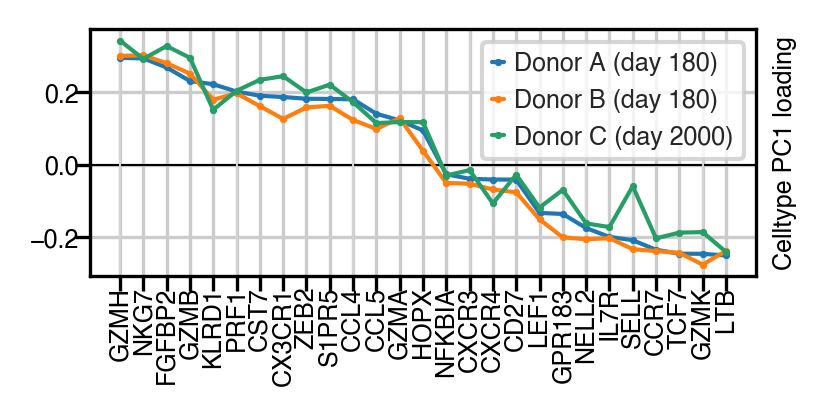

In [12]:
mm = 1 / 25.4

figsize=(70*mm,35*mm)
fig,ax = plt.subplots(1,1,figsize=figsize, dpi=300)
sns.set_style('white')
setfontsize()

ax.axhline(0, linewidth=0.5, color='k')
for i in range(6):
    ax.axvline(i*5, linewidth=0.5, color='lightgray')
for j,ds in enumerate(datasets):
    genelist = [gene for gene in genes_celltype if gene in adata[ds].var_names]
    plot_df = pd.DataFrame(adata[ds][:,genelist].var['Celltype_load'].copy())
    plot_df['Gene'] = plot_df.index
    #if plot_df.loc['GZMH','Celltype_load'] < 0:
    #    plot_df['Celltype_load'] *= -1
    plot_df.columns = ['Celltype loading','Gene']
    if j == 0:
        plot_df = plot_df.sort_values(by='Celltype loading', ascending=False)
    #display(plot_df)
    sns.lineplot(y='Celltype loading', x='Gene', data=plot_df, ax=ax, label=ds_titles[ds],
                linewidth=1.0, markers=True, marker='.', markersize=2.0, markeredgecolor=None)
    ax.tick_params(axis='x', rotation=90, pad=-1)
    ax.tick_params(axis='y', pad=-1)

ax.set_ylabel('Celltype PC1 loading')
ax.set_xlabel('')
ax.yaxis.set_label_position("right")

set_size(fig, figsize)
plt.savefig('Panels/Celltype_loadings.pdf', bbox_inches='tight')
plt.show()

This shows that our celltype score -- based on a weighted combination of 20something genes -- is nearly the same for the three donors (A1_06, A1_30, and JH).  So the celltype scores are comparable across the three datasets, even though they are defined separately.

# Panel:  Clonality of celltype scores.

Here we look at celltype scores for each of the ten biggest clones within each of the three datasets.  The first thing we do is we *order* the clones based on mean celltype score.  We accomplish this by creating an enumerated datatype for the cloneIDs... that way the ordering is consistent throughout the notebook. 

In [13]:
clonetype = {}
for ds in datasets:
    clone_cts = ads[ds].obs.groupby('clone_id').Celltype.mean().sort_values()
    clonetype[ds] = pd.CategoricalDtype(categories=list(clone_cts.index), ordered=True)
    ads[ds].obs['clone_id'] = ads[ds].obs['clone_id'].astype(clonetype[ds])

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Now we plot the celltype scores -- separated by clone and by donor.

In [14]:
ads[ds].obs

,Celltype,Donor,DonorDay,G2M_score,S_score,Timepoint,batch,clone_id,is_clone0,log1p_n_genes_by_counts,log1p_total_counts,log1p_total_counts_mt,n_counts,n_genes,n_genes_by_counts,obs_names,pct_counts_mt,phase,total_counts,total_counts_mt
obs_names,,,,,,,,,,,,,,,,,,,,
JHDex_136,0.088495,JH,JH_D2000,-0.167326,-0.472323,2000,22,C35,0,7.556951,8.034204,3.901435,3083.684326,1913,1913,JHDex_136,1.571931,G1,3083.684326,48.473389
JHDex_232,-0.336755,JH,JH_D2000,-0.052776,-1.217525,2000,22,C29,0,7.634821,8.082446,3.826386,3236.141602,2068,2068,JHDex_232,1.387343,G1,3236.141602,44.896393
JHDex_280,-0.212402,JH,JH_D2000,-0.094079,0.067279,2000,22,C87,0,7.643483,8.085395,3.953414,3245.701172,2086,2086,JHDex_280,1.574789,S,3245.701172,51.112957
JHDex_111,-0.281823,JH,JH_D2000,-0.717246,0.910144,2000,22,C87,0,7.624619,8.168797,3.970425,3528.093506,2047,2047,JHDex_111,1.474084,S,3528.093506,52.007076
JHDex_183,-0.221101,JH,JH_D2000,-0.357862,-0.078863,2000,22,C35,0,7.489971,8.041965,3.890801,3107.715820,1789,1789,JHDex_183,1.542937,G1,3107.715820,47.950085
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
JHDex_460,-0.369633,JH,JH_D2000,0.429534,0.561201,2000,23,C87,0,7.385851,7.890094,3.679606,2669.695801,1612,1612,JHDex_460,1.447010,S,2669.695801,38.630775
JHDex_676,0.094140,JH,JH_D2000,-0.169602,0.492211,2000,23,C27,0,7.393878,7.810555,3.629600,2465.497314,1625,1625,JHDex_676,1.488451,S,2465.497314,36.697731
JHDex_536,-0.342171,JH,JH_D2000,0.268385,-0.466901,2000,23,C87,0,7.413970,7.862676,3.758426,2597.463379,1658,1658,JHDex_536,1.612376,G2M,2597.463379,41.880867


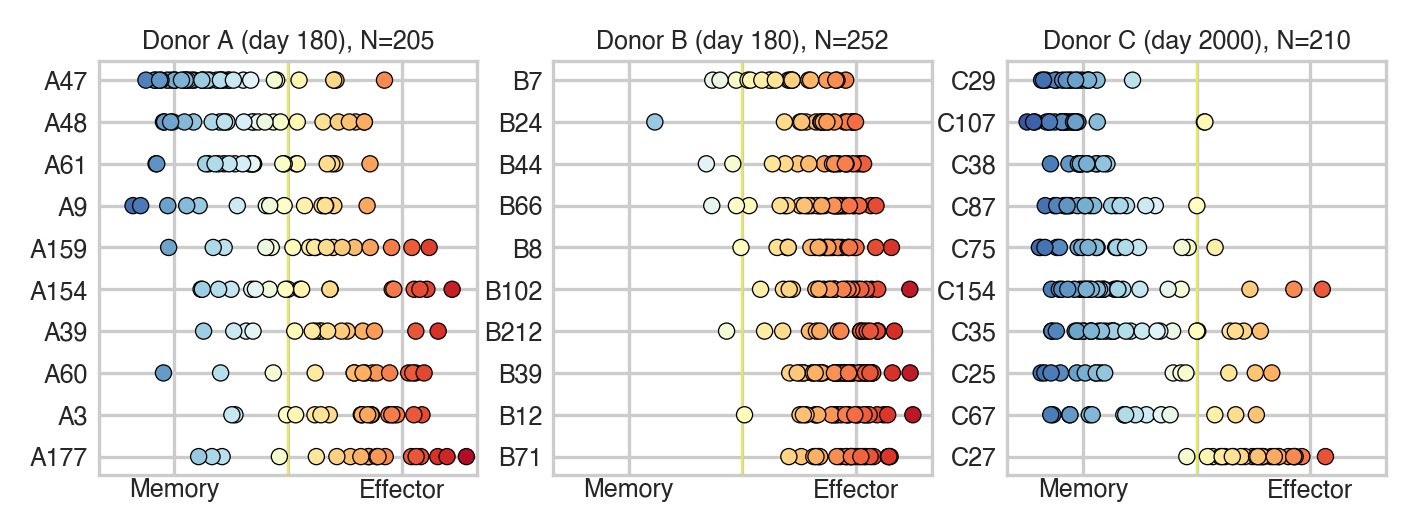

In [16]:
figsize=(120*mm,45*mm)
fig,ax = plt.subplots(1,3,figsize=figsize, sharex=True, dpi=300,
                     gridspec_kw={'wspace':0.2})

sns.set_style('whitegrid')
setfontsize()

for j,ds in enumerate(datasets[:3]):
    ax[j].axvline(0, color='yellow', linewidth=0.5, alpha=0.6, zorder=1)
    sns.scatterplot(y='clone_id', x='Celltype', hue='Celltype', data=ads[ds].obs, ax=ax[j],
                    palette='RdYlBu_r', edgecolor='k', s=15, legend=False,
                   zorder=2, hue_norm=(-0.5,0.5))
    ax[j].tick_params(axis='x', pad=0)
    ax[j].set_xlabel('')
    ax[j].set_ylabel('')
    ax[j].tick_params(axis='y', pad=-1)
    ax[j].set_xticks([-0.3,0,0.3])
    ax[j].set_xlim(-0.5,0.5)
    ax[j].set_xticklabels(['Memory','','Effector'], va='center')
    N = len(ads[ds].obs)
    ax[j].set_title(ds_titles[ds] + ', N={}'.format(N), y=0.97)

set_size(fig, figsize)
plt.savefig('Panels/Celltype_clonal.pdf', bbox_inches='tight')
plt.show()

We see that A30 is mostly EFF type, while JH is mostly MEM type.  We exploit this fact, and create new datasets consisting of just the EFF type cells from A30, and just the MEM type cells from JH (using the same clones as before).  

In [17]:
EFF_cells = (ads[a30].obs.Celltype > 0.1)
EFF_cells = EFF_cells[EFF_cells].index
ads['EFF'] = ads[a30][EFF_cells, :].copy()
EFF_clones = ads['EFF'].obs.clone_id.value_counts() > 10
EFF_clones = EFF_clones[EFF_clones].index
EFF_cells = ads['EFF'].obs.clone_id.isin(EFF_clones)
EFF_cells = EFF_cells[EFF_cells].index
ads['EFF'] = ads['EFF'][EFF_cells, :]
ads['EFF'].obs.clone_id.value_counts()

B39     45
B66     31
B8      25
B12     25
B102    23
B71     23
B24     18
B44     15
B212    14
Name: clone_id, dtype: int64

In [18]:
MEM_cells = (ads[jh].obs.Celltype < -0.1)
MEM_cells = MEM_cells[MEM_cells].index
ads['MEM'] = ads[jh][MEM_cells, :].copy()
MEM_clones = ads['MEM'].obs.clone_id.value_counts() > 10
MEM_clones = MEM_clones[MEM_clones].index
MEM_cells = ads['MEM'].obs.clone_id.isin(MEM_clones)
MEM_cells = MEM_cells[MEM_cells].index
ads['MEM'] = ads['MEM'][MEM_cells, :]
ads['MEM'].obs.clone_id.value_counts()

C107    24
C35     22
C154    21
C87     20
C29     17
C75     15
C38     14
C67     11
Name: clone_id, dtype: int64

To create these EFF and MEM datasets, we have thrown out all non-EFF and non-MEM cells, and kept only those clones with more than 10 cells.  This keeps nine clones from A30, and eight clones from JH.

In [19]:
ds_titles['EFF'] = 'Donor B, {} EFF Cells'.format(len(ads['EFF'].obs))
ds_titles['MEM'] = 'Donor C, {} MEM Cells'.format(len(ads['MEM'].obs))
clonetype['EFF'] = clonetype[a30]
clonetype['MEM'] = clonetype[jh]
datasets = ['A1_06_D180', 'A1_30_D180', 'JH_D2000', 'EFF', 'MEM']

In [20]:
ads['EFF'].obs.clone_id = ads['EFF'].obs.clone_id.astype(clonetype['EFF'])
ads['MEM'].obs.clone_id = ads['MEM'].obs.clone_id.astype(clonetype['MEM'])

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


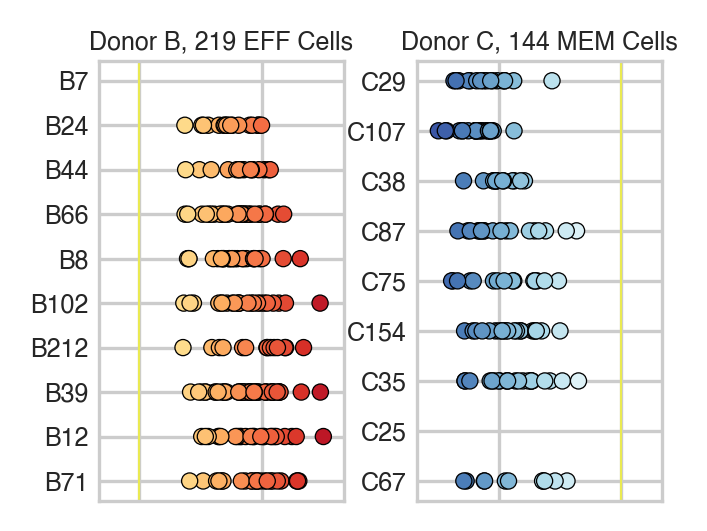

In [22]:
figsize=(60*mm,45*mm)
fig,ax = plt.subplots(1,2,figsize=figsize, dpi=300,
                     gridspec_kw={'wspace':0.3})

sns.set_style('whitegrid')
setfontsize()

for j,ds in enumerate(['EFF','MEM']):
    ax[j].axvline(0, color='yellow', linewidth=0.5, alpha=0.6, zorder=1)
    sns.scatterplot(y='clone_id', x='Celltype', hue='Celltype', data=ads[ds].obs, ax=ax[j],
                    palette='RdYlBu_r', edgecolor='k', s=15, legend=False,
                   zorder=2, hue_norm=(-0.5,0.5))
    ax[j].tick_params(axis='x', pad=0)
    ax[j].set_xlabel('')
    ax[j].set_ylabel('')
    ax[j].tick_params(axis='y', pad=-1)
    ax[j].set_xticks([-0.3,0,0.3])
    if ds == 'EFF':
        ax[j].set_xlim(-0.1,0.5)
    else:
        ax[j].set_xlim(-0.5,0.1)
    ax[j].set_xticklabels(['','',''])
    #ax[j].set_xticklabels(['Memory','','Effector'], va='center')
    ax[j].set_title(ds_titles[ds], y=0.97)
    
set_size(fig, figsize)
plt.savefig('Panels/Celltype_clonal_EFFMEM.pdf', bbox_inches='tight')
plt.show()

# Adding permuted labels to AnnData objects

We will be running permutation tests to find clonal signals in our data.  For this purpose, we will permute the clone-labels on many of our cells (within each celltype and brain).  

The following is a specialized tool for permutation tests.  It produes permutations which disrupt existing group structures.  For example, if we want 10 permutations of clone labels, we produce 100 permutations instead.  We "score" these by looking at how many distinct labels each old clone receives.  I.e., if an old clone A has three cells 1,2,3, and these are assigned labels B,C,D instead of A,A,A, then we give it a score of 3 (three distinct labels).  We then take the top 10 permutations, by this score.  

This mitigates some issues with clonal structure being preserved by some permutations and not by others... a significant issue when there are pretty small samples.

In [23]:
def make_shuff(meta, no_shuffs=10, topratio = 10):
    tot_shuffs = no_shuffs * topratio
    ms_df = pd.DataFrame(index=meta.index, columns=range(tot_shuffs))
    ms_df = pd.concat([meta.astype(str) for j in range(tot_shuffs)], axis=1)
    
    ms_vals = ms_df.values
    [np.random.shuffle(x) for x in ms_vals.T]
    
    ms_df.columns = ['Shuffle_{}'.format(j) for j in range(tot_shuffs)]
    scores = ms_df.groupby(meta).nunique().sum()
    good_shuffs = scores.sort_values()[-no_shuffs:].index
    ms_df = ms_df[good_shuffs].astype('category')
    ms_df.columns = ['Shuffle_{}'.format(j) for j in range(no_shuffs)]
    return ms_df

In [24]:
no_shuffs = 1100

for ds in datasets:
    # ads[ds].obs.clone_id = ads[ds].obs.clone_id.astype(str)
    clone_shuffs = make_shuff(ads[ds].obs.clone_id, no_shuffs = no_shuffs)
    shuff_cols = clone_shuffs.columns
    ads[ds].obs[shuff_cols] = clone_shuffs
    print('Shuffled clone labels produced for dataset with {} cells'.format(ads[ds].shape[0]))

Shuffled clone labels produced for dataset with 205 cells
Shuffled clone labels produced for dataset with 252 cells
Shuffled clone labels produced for dataset with 210 cells
Shuffled clone labels produced for dataset with 219 cells
Shuffled clone labels produced for dataset with 144 cells


In [25]:
ads[ds].obs # Scroll right to see shuffled clone labels.

,Celltype,Donor,DonorDay,G2M_score,S_score,Timepoint,batch,clone_id,is_clone0,log1p_n_genes_by_counts,...,Shuffle_1090,Shuffle_1091,Shuffle_1092,Shuffle_1093,Shuffle_1094,Shuffle_1095,Shuffle_1096,Shuffle_1097,Shuffle_1098,Shuffle_1099
obs_names,,,,,,,,,,,,,,,,,,,,,
JHDex_232,-0.336755,JH,JH_D2000,-0.052776,-1.217525,2000,22,C29,0,7.634821,...,C29,C29,C107,C35,C29,C29,C35,C38,C35,C154
JHDex_280,-0.212402,JH,JH_D2000,-0.094079,0.067279,2000,22,C87,0,7.643483,...,C35,C87,C75,C107,C38,C107,C35,C29,C38,C107
JHDex_111,-0.281823,JH,JH_D2000,-0.717246,0.910144,2000,22,C87,0,7.624619,...,C35,C87,C38,C154,C75,C87,C35,C107,C67,C67
JHDex_183,-0.221101,JH,JH_D2000,-0.357862,-0.078863,2000,22,C35,0,7.489971,...,C154,C35,C87,C107,C154,C107,C75,C38,C154,C107
JHDex_87,-0.169374,JH,JH_D2000,0.155526,-0.320373,2000,22,C29,0,7.663408,...,C154,C29,C38,C87,C87,C35,C35,C67,C87,C107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
JHDex_158,-0.340436,JH,JH_D2000,0.837581,0.499959,2000,22,C154,0,7.467942,...,C35,C29,C67,C29,C38,C154,C154,C87,C67,C107
JHDex_902,-0.104558,JH,JH_D2000,0.540554,-0.889709,2000,24,C35,0,7.660114,...,C154,C87,C154,C35,C154,C154,C107,C75,C107,C87
JHDex_460,-0.369633,JH,JH_D2000,0.429534,0.561201,2000,23,C87,0,7.385851,...,C38,C107,C107,C67,C87,C35,C67,C87,C67,C35


In [26]:
from time import time
from scipy.stats import f_oneway

def make_pvals(ad, real_group, shuffle_label = 'Shuffle', no_shuffs=100):
    '''
    Expects an AnnData object ad.
    real_group is usually "cloneID", or the equivalent.
    Also expects a lot of shuffled real_group labels, called
    Shuffle_0, Shuffle_1, up to Shuffle_n, where n = no_shuffs.
    real_group and shuffles should be within the ad.obs dataframe.
    Computes p-values by applying scipy's f_oneway to each column of shuffled labels.
    Vectorized for all genes at once.
    '''
    before = time()    
    cols = [real_group] + [shuffle_label + '_' + str(j) for j in range(no_shuffs)]
    pval_df = pd.DataFrame(columns=cols)

    groups = ad.obs[real_group].unique()
    ad_df = ad.to_df()
    pval_df = ad.obs[cols].apply(lambda col : f_oneway(*[ad_df[col == k] for k in groups])[1])
    pval_df.index = ad.var_names
    after = time()
    print('{:1.0f} seconds to compute ANOVA F p-values for {} cells and {} groups.'.format(after - before,
                                                                                          ad.shape[0], len(groups)))
    return pval_df

In [27]:
all_pvals = {}
for ds in datasets:
    all_pvals[ds] = make_pvals(ads[ds], 'clone_id', no_shuffs = no_shuffs)

52 seconds to compute ANOVA F p-values for 205 cells and 10 groups.
63 seconds to compute ANOVA F p-values for 252 cells and 10 groups.
50 seconds to compute ANOVA F p-values for 210 cells and 10 groups.
57 seconds to compute ANOVA F p-values for 219 cells and 9 groups.
38 seconds to compute ANOVA F p-values for 144 cells and 8 groups.


In [28]:
all_pvals[ds]

,clone_id,Shuffle_0,Shuffle_1,Shuffle_2,Shuffle_3,Shuffle_4,Shuffle_5,Shuffle_6,Shuffle_7,Shuffle_8,...,Shuffle_1090,Shuffle_1091,Shuffle_1092,Shuffle_1093,Shuffle_1094,Shuffle_1095,Shuffle_1096,Shuffle_1097,Shuffle_1098,Shuffle_1099
gene_name,,,,,,,,,,,,,,,,,,,,,
WASH7P,0.633206,0.992983,0.836795,0.216871,0.604524,0.471069,0.690629,0.257098,0.190564,0.769820,...,0.100253,0.625313,0.682633,0.414703,0.563525,0.679839,0.052664,0.770521,0.330644,0.775591
MTND1P23,0.384085,0.266514,0.129897,0.037087,0.693219,0.352458,0.281186,0.489097,0.369833,0.659388,...,0.881391,0.593054,0.008870,0.065847,0.294582,0.823547,0.309713,0.384069,0.928804,0.260298
MTND2P28,0.359258,0.201135,0.077503,0.444977,0.750342,0.571898,0.686036,0.654187,0.763774,0.214733,...,0.890372,0.825883,0.842733,0.520323,0.341212,0.534350,0.779801,0.740541,0.036847,0.626766
hsa-mir-6723,0.692698,0.774133,0.518110,0.385118,0.112039,0.566719,0.919586,0.593631,0.772679,0.019723,...,0.494762,0.793050,0.517256,0.378129,0.700194,0.377288,0.603724,0.936795,0.157426,0.100055
RP5-857K21.7,0.617916,0.517185,0.939033,0.956362,0.720120,0.571237,0.311749,0.794310,0.247789,0.084486,...,0.370971,0.966152,0.327771,0.740352,0.517909,0.751753,0.966013,0.172213,0.118311,0.065014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
F8A2-1,0.037904,0.691288,0.665796,0.055592,0.504643,0.287935,0.907026,0.860805,0.489545,0.200456,...,0.797509,0.215002,0.346211,0.114971,0.548777,0.479110,0.822973,0.621550,0.892773,0.681902
TMLHE-1,0.375296,0.013257,0.434783,0.384232,0.163417,0.310814,0.785152,0.127927,0.097264,0.058108,...,0.270110,0.596251,0.230437,0.669229,0.849825,0.097126,0.602093,0.972544,0.477284,0.111882
VAMP7,0.416163,0.367771,0.594059,0.266657,0.287855,0.443066,0.340346,0.507656,0.868528,0.184259,...,0.867337,0.393164,0.862929,0.071995,0.793272,0.777562,0.410760,0.717754,0.718389,0.463116


In [29]:
import matplotlib.patches as patches

In [30]:
def permplot(ds, pcut=0.01, figwidth = None, xrange=None):
    if figwidth:
        figsize=(figwidth, 20*mm)
    else:
        figsize = (36*mm, 20*mm)
    sns.set_style('white', rc={"axes.facecolor": (0, 0, 0, 0)})
    setfontsize()
    fig,ax = plt.subplots(1,1, figsize=figsize, dpi=300, 
                          gridspec_kw={'wspace':0.2})
    num_sig = (all_pvals[ds] < pcut).sum()
    sig_med = num_sig.drop('clone_id').median()
    sig_high = num_sig.drop('clone_id').quantile(0.95)
    nsig = num_sig['clone_id']
    N = len(ads[ds])
    K = ads[ds].obs.clone_id.nunique()
            
    sns.kdeplot(num_sig.drop('clone_id'), clip_on=False, shade=True, 
                alpha=0.4, ax=ax, legend=False)
    sns.kdeplot(num_sig.drop('clone_id'), clip_on=False, color='w', 
                alpha=1, ax=ax, legend=False)
    kde_curve = ax.lines[0]
    kde_y = kde_curve.get_ydata()
    ky_max = kde_y.max()
    ax.set_yticks([])
    ax.set_title('')
    ax.set_ylim(0,ky_max*1.5)
            
    #ax.text(0, 0.75, '{}, N={}, K={}'.format(ds_titles[ds],N,K), fontweight="bold", 
    #        color='black', ha="left", va="center", transform=ax.transAxes)
            
    ax.axvline(nsig, ymax=0.3, color='red')
    ax.axvline(sig_med, ymax=0.3, linewidth=0.5, color='blue')
    ax.axvline(sig_high, ymax=0.3, linewidth=0.5, color='orange')
    trans = ax.get_xaxis_transform()
    #ax.text(0, .65, 'N={}, K={}.'.format(N,K), fontweight="bold", 
    #        color='black', ha="left", va="center", transform=ax.transAxes)
            
    ax.text(0, .9, '{:d} excess clonal genes.'.format(int(nsig - sig_med)),  
            color='black', ha="left", va="center", transform=ax.transAxes)
            

    ar_y = ky_max * 0.45
    arr = patches.FancyArrowPatch((sig_med, ar_y), (nsig, ar_y), arrowstyle='<->', 
                                  shrinkA=0, shrinkB=0,
                                  mutation_scale=5, linewidth=0.5, color='k', zorder=10)
    ax.add_patch(arr)
            
    if nsig > (sig_high+20):
        ax.text(0.15, .7, '{:d} beyond 95th percentile.'.format(int(nsig - sig_high)),  
                color='black', ha="left", va="center", transform=ax.transAxes)
        arr = patches.FancyArrowPatch((sig_high, ar_y*0.7), (nsig, ar_y*0.7), arrowstyle='<->',
                                      shrinkA=0, shrinkB=0,
                                      mutation_scale=5, linewidth=0.5, color='k', zorder=10)
        ax.add_patch(arr)
                
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(axis='x', pad=-1)
    if xrange:
        ax.set_xlim(xrange)
    sns.despine(left=True)
    set_size(fig, figsize)
    plt.savefig('Panels/{}_excess_genes.pdf'.format(ds), bbox_inches='tight')
    plt.show()

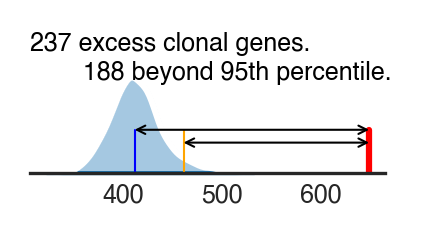

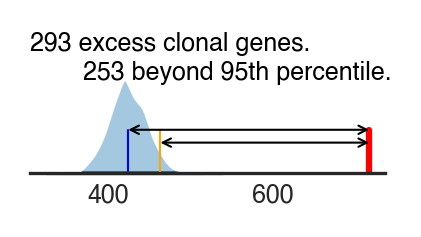

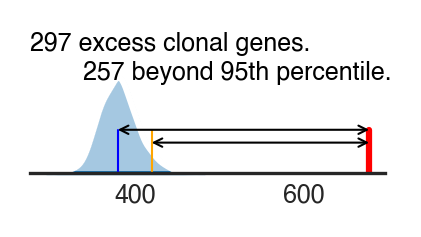

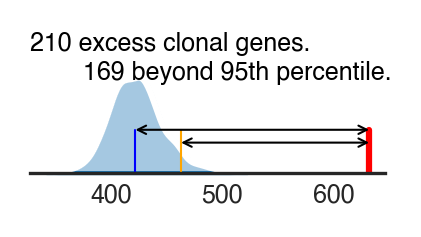

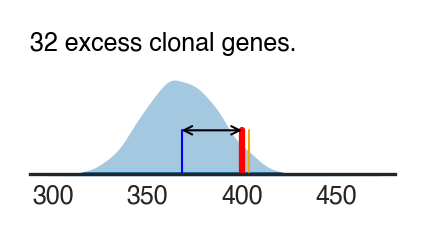

In [31]:
for ds in datasets:
    permplot(ds, pcut=0.05)

## Identifying clonal genes

We use the permuted clone labels together with the ANOVA F p-values to identify clonal genes while managing false discovery rate.

In [32]:
for ds in datasets:
    ads[ds].var['nz_ratio'] = (ads[ds].to_df() > 0).sum() / ads[ds].n_obs

In [33]:
shuff_cols = ['Shuffle_'+str(j) for j in range(1000)]
test_cols = ['clone_id'] + ['Shuffle_'+str(j) for j in range(1000,1100)]

In [34]:
def adj_pval_binned(ad, pv, test_cols, shuff_cols, bins=20, corrected=True, verbose=False):
    nz_cut = pd.qcut(ad.var.nz_ratio, bins)
    p_adj_list = []
    for nz_bin in nz_cut.unique():
        if verbose:
            print('Processing genes with nonzero ratio in {}'.format(nz_bin))
        genes_bin = nz_cut[nz_cut == nz_bin].index
        bin_pvals = pv.loc[genes_bin]
        shuff_pvals = bin_pvals[shuff_cols]
        now_time = time()
        shuff_pvals = np.sort(shuff_pvals, axis=None)
        then_time = time()
        if verbose:
            print('Sorting {} p-values took {} seconds.'.format(len(shuff_pvals), then_time - now_time))
        test_pvals = bin_pvals[test_cols].values
        now_time = time()
        places = np.searchsorted(shuff_pvals, test_pvals )
        then_time = time()
        if verbose:
            print('Finding places for {} p-values in sorted list took {} seconds.'.format(test_pvals.shape, 
                                                                                         then_time-now_time))
        denominator = 1 + len(shuff_pvals)
        numerator = 1 + places
        p_adj = pd.DataFrame(numerator / denominator, index=bin_pvals.index, columns=test_cols)
        if corrected:
            corrector = test_pvals.shape[0]
            p_adj = (p_adj * corrector).clip(0,1)
        p_adj_list.append(p_adj)
    return pd.concat(p_adj_list)

In [35]:
p_permadj = {}
for ds in datasets:
    print('Adjusting p-values for {}'.format(ds))
    p_permadj[ds] = adj_pval_binned(ads[ds], all_pvals[ds], test_cols, shuff_cols, corrected=True)

Adjusting p-values for A1_06_D180
Adjusting p-values for A1_30_D180
Adjusting p-values for JH_D2000
Adjusting p-values for EFF
Adjusting p-values for MEM


In [36]:
sig_genes = {}
for ds in datasets:
    sig_df = (p_permadj[ds] < 0.05)
    #print(ds, sig_df.sum())
    sig_genes[ds] = list(sig_df.clone_id[sig_df.clone_id].index)
    sig_genes[ds].sort()
    print('The {} significant genes for {} are {}'.format(len(sig_genes[ds]), ds, ', '.join(sig_genes[ds])))
    FDs = sig_df.sum()[1:].mean()
    print('{} expected by chance.'.format(FDs))
    hrule()

The 32 significant genes for A1_06_D180 are AOAH, C1orf228, CCL4, CCR7, CD300A, COL18A1, CST7, FCGR3A, FCRL6, FGFBP2, FOS, GNLY, GPR56, GZMB, GZMH, GZMK, IFNG-AS1, IL7R, ITGAM, KCNN4, KLRB1, KLRD1, LDHB, LTB, NKG7, NOSIP, PAX8-AS1, RHOH, RP11-23P13.6, S1PR5, SELL, TCF7
0.96 expected by chance.
The 35 significant genes for A1_30_D180 are ALOX5AP, AMICA1, C1orf162, CACNA2D4, CD28, CD300A, CD5, CD8B, DDX10, DFNB31, FCGR3A, GFPT2, GNLY, GPR56, GZMH, HAVCR2, HLA-DRB1, HLA-DRB5, HOPX, IL7R, ITGB1, ITM2A, KLRD1, KLRG1, MT-ND5, NCAPG2, NKG7, NSG1, RNVU1-19, RP11-23P13.6, SATB1, SPON2, TSPYL2-1, TTPAL, ZNF683
1.04 expected by chance.
The 51 significant genes for JH_D2000 are ANXA2, AOAH, APMAP, BZRAP1, CAMK4, CD300A, CD63, CD7, CD8B, COL6A2, CST7, CTSW, DGKA, EFHD2, F2R, FAM211A-AS1, FCGR3A, FCGR3B, FCRL3, FCRL6, FGFBP2, FGR, GNLY, GPR56, GZMB, GZMH, GZMK, IL2RB, IL7R, ITGAL, ITGAM, KLRB1, KLRC4-KLRK1, LDLRAP1, LGALS1, LTB, NKG7, NOSIP, PRF1, PRSS21, RPL4, RPLP0, RPLP0P6, SIT1, STOM, TADA3, TIG

In [46]:
for ds in datasets[:5]:
    pser = p_permadj[ds].loc[sig_genes[ds], 'clone_id']
    pser.name = 'adjusted p-value'
    pser = pser.sort_values()
    filename = 'sig_genes_padj_'+ds+'.csv'
    pser.to_csv(filename)

In [47]:
p_sig = {}
for ds in datasets:
    p_sig[ds] = all_pvals[ds]['clone_id'].loc[sig_genes[ds]].sort_values()
    print(ds)
    display(p_sig[ds][:10])
    hrule()

A1_06_D180


gene_name
KLRB1       8.548724e-12
GZMH        1.291962e-11
GNLY        2.195030e-11
NKG7        2.622648e-10
KLRD1       1.151013e-09
C1orf228    1.904280e-09
CD300A      4.581816e-09
KCNN4       3.014960e-08
PAX8-AS1    7.191569e-08
SELL        9.761067e-08
Name: clone_id, dtype: float64

A1_30_D180


gene_name
GZMH            4.226478e-17
AMICA1          2.449141e-10
GNLY            3.195449e-10
SPON2           1.743040e-08
GFPT2           9.057701e-08
CD8B            1.213665e-07
HLA-DRB1        1.227888e-07
RP11-23P13.6    2.444940e-07
IL7R            4.194347e-07
ITM2A           4.802810e-07
Name: clone_id, dtype: float64

JH_D2000


gene_name
GZMB      1.177240e-37
FCGR3A    1.557921e-28
GZMH      6.275643e-27
TIGIT     5.050347e-24
ZNF683    1.712470e-20
GNLY      4.397361e-19
FCGR3B    1.236872e-17
NKG7      3.058785e-11
GZMK      1.265223e-10
PRF1      1.737040e-10
Name: clone_id, dtype: float64

EFF


gene_name
GNLY        1.082682e-08
CD8B        5.453625e-08
HLA-DRB1    1.904275e-07
DDX10       2.188467e-07
AMICA1      3.127377e-07
ITM2A       5.355093e-07
KLRD1       6.066743e-07
ZNF683      7.373748e-07
CACNA2D4    1.417610e-06
NSG1        1.978432e-06
Name: clone_id, dtype: float64

MEM


gene_name
USP30-AS1    2.952909e-07
LENG1        9.948926e-07
STOM         8.270852e-06
CD8B         1.194467e-05
Name: clone_id, dtype: float64

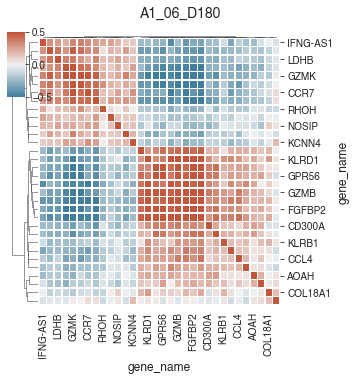

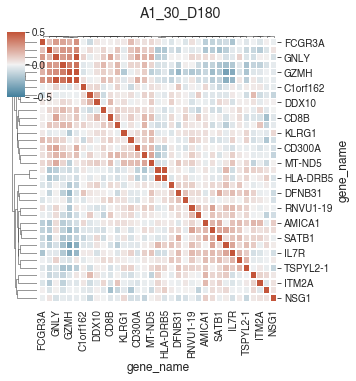

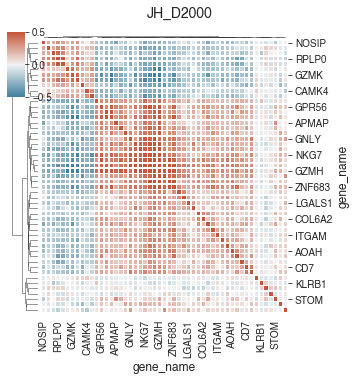

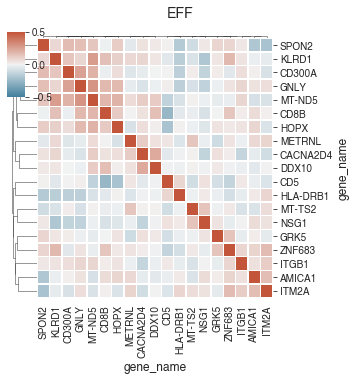

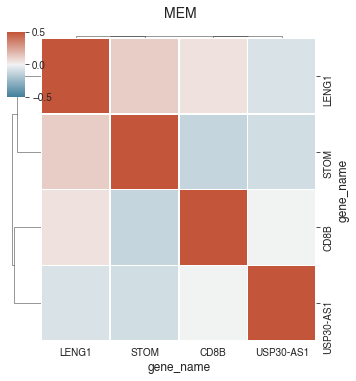

In [48]:
desetfontsize()
for ds in datasets:
    corr = ads[ds].to_df()[sig_genes[ds]].corr()
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    g = sns.clustermap(corr, cmap=cmap, vmax=0.5, vmin=-0.5, center=0,
                         linewidths=.5, cbar_kws={"shrink": .5},
                         dendrogram_ratio = (0.1,0.01), figsize=(5,5))
    g.fig.suptitle(ds, y=1.05)

    plt.show()

In [49]:
ads_z = {}
for ds in datasets:
    ads_z[ds] = sc.pp.scale(ads[ds], copy=True)

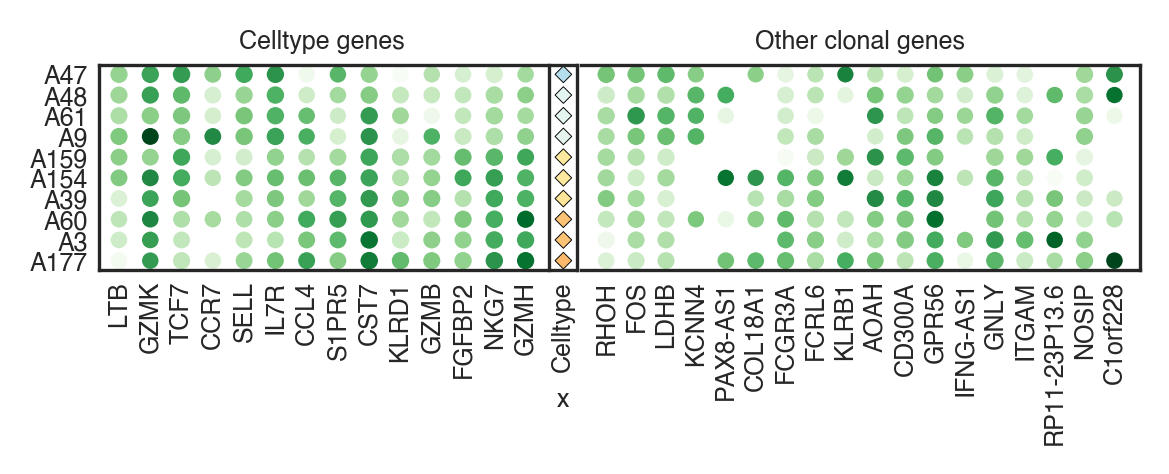

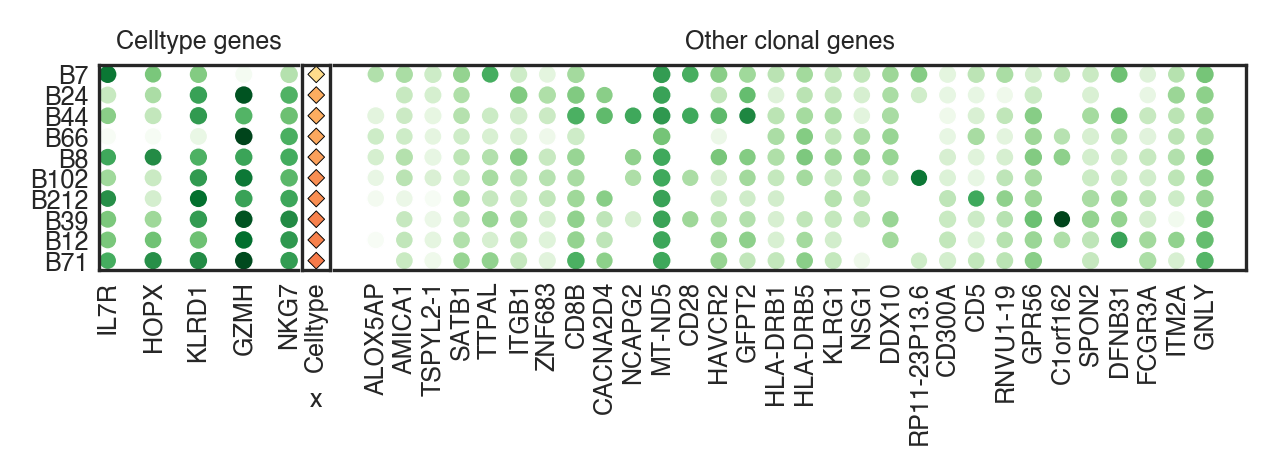

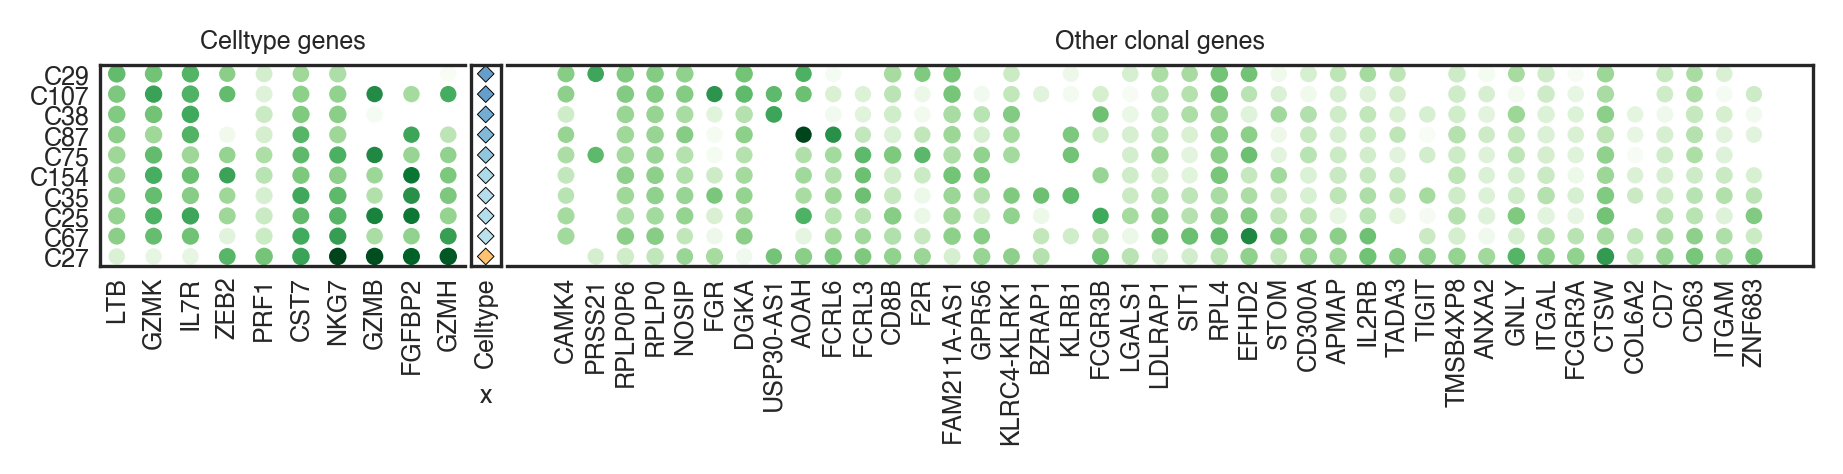

In [51]:
from scipy.stats import zscore
mm = 1 / 25.4

for ds in datasets[:3]:
    sns.set_style("white")
    setfontsize()
    
    # Celltype genes
    plot_rows = ads[ds].obs.clone_id.sort_values().index
    plot_cols = [gene for gene in genes_celltype if gene in ads[ds].var_names]
    plot_cols = [gene for gene in plot_cols if gene in sig_genes[ds]]
    plot_cols = list(ads[ds][:,plot_cols].var['Celltype_load'].sort_values().index)
    plot_df = ads[ds].to_df().loc[plot_rows, plot_cols].copy()
    plot_df = (plot_df - plot_df.min())
    plot_df = (plot_df / plot_df.max())  
    #clonal_means = plot_df.groupby(ads[ds].obs.clone_id).mean()
    clonal_means = plot_df.groupby(ads[ds].obs.clone_id).apply(lambda s : s.sum() / (s>0.01).sum() )
    clonal_ons = plot_df.groupby(ads[ds].obs.clone_id).apply(lambda s : (s>0).sum() / len(s))
    clonal_means = clonal_means.melt(ignore_index=False)
    clonal_means.columns = ['gene_name','mean']
    clonal_means['clone_id'] = clonal_means.index

    clonal_ons = clonal_ons.melt(ignore_index=False)
    
    dots_df_ct = pd.DataFrame(clonal_means)
    dots_df_ct['on_ratio'] = clonal_ons['value']
    
    # Celltype scores
    ct_df = pd.DataFrame(ads[ds].obs['Celltype'].groupby(ads[ds].obs.clone_id).mean())
    ct_df.columns = ['Celltype']
    ct_df['clone_id'] = ct_df.index
    
    # Non-Celltype genes
    plot_rows = ads[ds].obs.clone_id.sort_values().index
    plot_cols = [gene for gene in sig_genes[ds] if gene not in genes_celltype]
    plot_df = ads[ds].to_df().loc[plot_rows, plot_cols].copy()
    plot_df = (plot_df - plot_df.min())
    plot_df = (plot_df / plot_df.max())  
    #clonal_means = plot_df.groupby(ads[ds].obs.clone_id).mean()
    clonal_means = plot_df.groupby(ads[ds].obs.clone_id).apply(lambda s : s.sum() / (s>0).sum() )
    clonal_ons = plot_df.groupby(ads[ds].obs.clone_id).apply(lambda s : (s>0).sum() / len(s))
    clonal_means = clonal_means.melt(ignore_index=False)
    clonal_means.columns = ['gene_name','mean']
    clonal_means['clone_id'] = clonal_means.index

    clonal_ons = clonal_ons.melt(ignore_index=False)
    
    dots_df = pd.DataFrame(clonal_means)
    dots_df['on_ratio'] = clonal_ons['value']
    
    genesort = dots_df.groupby('gene_name')['mean'].apply(
        lambda s : s.idxmax()).astype(clonetype[ds]).sort_values()

    dots_df = pd.concat([dots_df[dots_df['gene_name'] == gene] for gene in genesort.index])
    
    ct_gene_no = dots_df_ct.gene_name.nunique()
    gene_no = dots_df.gene_name.nunique()
    
    figwidth = (gene_no+ct_gene_no+1)*3*mm
    figheight = 40*mm
    fig, ax = plt.subplots(1,3, figsize=(figwidth,figheight), dpi=300, sharey=True,
                          gridspec_kw = {'width_ratios':[ct_gene_no+2,1,gene_no+2], 'wspace':0.01})
    setfontsize()
    
    sns.scatterplot(x='gene_name', y='clone_id', hue='mean', size='on_ratio', 
                    size_norm=(0,20), data=dots_df_ct, legend=False, palette='Greens', ax=ax[0])
    
    ct_df['x'] = 0
    sns.scatterplot(x='x', y='clone_id', hue='Celltype', data=ct_df, ax=ax[1], s=8, 
                    palette='RdYlBu_r', edgecolor='k', marker='D', hue_norm=(-0.5,0.5), legend=False)
      
    sns.scatterplot(x='gene_name', y='clone_id', hue='mean', size='on_ratio', 
                    size_norm=(0,20), data=dots_df, legend=False, palette='Greens', ax=ax[2])
    
    
    #ax[1].set_yticklabels([])
    ax[1].set_ylabel('')
    ax[1].set_xticks([0])
    ax[1].set_xticklabels(['Celltype'])
    ax[0].tick_params(axis='x', rotation=90, pad=-1)
    ax[0].spines["right"].set_visible(False)
    ax[0].set_xlabel('Celltype genes')
    ax[0].xaxis.set_label_position('top')
    ax[2].set_xlabel('Other clonal genes')
    ax[2].xaxis.set_label_position('top')
    ax[2].spines["left"].set_visible(False)
    ax[1].tick_params(axis='x', rotation=90, pad=-1)
    ax[2].tick_params(axis='x', rotation=90, pad=-1)
    ax[0].tick_params(axis='y', pad=-1)
    ax[0].set_ylabel('')
    ax[0].set_yticks(dots_df.clone_id.unique())
    #plt.suptitle(ds)
    set_size(fig, (figwidth, figheight))
    plt.savefig('Panels/{}_dotplot.pdf'.format(ds), bbox_inches='tight')
    plt.show()

In [52]:
from matplotlib.colors import Normalize

In [55]:
def minivio(gene, ad, prop='clone_id', proporder=None, hide_clones = False, show_ons = False,
               clip = False, style='binary', filename=None):

    df = pd.DataFrame(ad.to_df()[gene].copy())
    df[prop] = ad.obs[prop]
    df['Celltype'] = ad.obs['Celltype']
    df_noclone = df.copy()
    df_noclone[prop] = 'All'
    #create a figure
    sns.set_style('whitegrid')
    setfontsize()
    figsize=(36*mm,20*mm)
    fig,ax = plt.subplots(1,2,figsize=figsize, dpi=300, sharey=True,
                         gridspec_kw={'width_ratios':[4,1],
                                     'wspace':0.05})
    
    ax[0].tick_params(axis='both', which='major', pad=-2)
    # ax.legend_.remove()
    
    if style == 'tune':
        genemean = df[gene].mean()
        genestd = df[gene].std()
        # Create the violin
        sns.violinplot(x=prop, y=gene, inner=None, scale='width', order=proporder, data=df, alpha=0.2, 
                       color='lightgray', linewidth=0.4, cut=0, ax=ax[0])
        #sns.swarmplot(x=prop, y=gene, order=proporder, data=df, size=0.75, ax=ax[0])
        sns.stripplot(x=prop, y=gene, order=proporder, data=df, size=0.75, ax=ax[0])
        ax[0].set_ylim((max(df[gene].min() - 0.25,0), df[gene].max() + 0.25))
        gene_range = df[gene].max() - df[gene].min()
    elif style == 'binary':
        
        maxes = df.groupby(prop).max()[gene]
        nonzeros = df.groupby(prop).apply(lambda x : (x > np.log1p(10)).sum() / len(x))[gene]
        if show_ons:
            for x,clone in enumerate(clones):
                nz_label = int(nonzeros[clone]*100)
                if nz_label > 0:
                    ax.text(x, maxes[clone]+0.2, '{}%'.format(nz_label), 
                            ha='center', rotation=75) # '.{:0>2}'.format(int(nonzeros[clone]*100)), ha='center')

        sns.violinplot(x=prop, y=gene, inner=None, scale='width', order=proporder, data=df,
                       alpha=0.15, linewidth=0.4, cut=0, ax=ax[0])
        for violin in ax[0].collections:
            violin.set_alpha(0.15)
        
        #Create a matplotlib colormap from the sns seagreen color palette
        cmap = sns.color_palette("RdYlBu_r", as_cmap=True )
        # Normalize to the range of possible values from df["c"]
        norm = Normalize(vmin=-0.5, vmax=0.5)
        # create a color dictionary (value in c : color from colormap) 
        colors = {}
        for cval in df[df[gene] > 0].Celltype:
            colors.update({cval : cmap(norm(cval))})
        
        #sns.swarmplot(x=prop, y=gene, order=proporder, data=df[df[gene] > 0], 
        #              hue='Celltype', size=0.75, ax=ax[0], palette=colors) #'RdYlBu_r')
                     #vmin=-0.5, vmax=0.5)
        sns.stripplot(x=prop, y=gene, order=proporder, data=df[df[gene] > 0], 
                      hue='Celltype', size=0.75, ax=ax[0], palette=colors) #'RdYlBu_r')
                     #vmin=-0.5, vmax=0.5)
        ax[0].get_legend().remove()
        gene_range = df[gene].max()
        ax[0].set_ylim((-0.15*gene_range, df[gene].max()*1.15))
    
    sns.violinplot(x=prop, y=gene, data=df_noclone, color='lightgray', width=1,
                   inner=None, saturation=0.8, linewidth=0.4, cut=0, ax=ax[1], legend=False)
    sns.swarmplot(x=prop, y=gene, data=df_noclone, color='k', size=0.75, ax=ax[1])
    
    df_zeros = pd.DataFrame(df.groupby(prop).apply(lambda s : (s==0).sum() / len(s) ))
    #display(df_zeros)
    df_zeros.columns = ['Zero count',prop,'Celltype']
    df_zeros[prop] = df_zeros.index
    #df_zeros[prop] = df_zeros.index
    df_zeros['yo'] = 0
    sns.scatterplot(x=prop, y='yo', size='Zero count', hue=prop, sizes=(0,6), size_norm = (0,1), data=df_zeros, 
                    edgecolor='k', linewidth=0.25, ax=ax[0], legend=False)
    
    
    ct_df = pd.DataFrame(ad.obs.Celltype.groupby(ad.obs[prop]).mean())
    ct_df[prop] = ct_df.index
    #ct_df = ct_df.sort_values()
    ct_df['bott'] = -0.1*gene_range
    sns.scatterplot(x=prop, y='bott', marker='D', s=3, sizes=(5,5), hue='Celltype', data=ct_df, 
                    hue_norm = (-0.5, 0.5), palette='RdYlBu_r', ax=ax[0], legend=False)
    
    #for j,cl in enumerate(ct_df.index):
    #    ax[0].add_patch(Rectangle((j,0),1,-0.1, color=ct_df[cl], fill=True,clip_on=False))
    ax[0].set_xlabel('')
    ax[1].set_xlabel('')
    ax[0].set_ylabel('')
    ax[1].set_ylabel('')
    ax[0].tick_params(axis='both', which='major', pad=-1)
    
    ax[0].set_yticks([0,np.floor(df[gene].max()*0.6), np.floor(df[gene].max()*1.15)])
    if hide_clones:
        ax[0].set_xticks([])
        ax[1].set_xticks([])
    #ax.set_xlabel('Clone')
    #ax.set_ylabel('$log_2({})$.'.format(genename))
    
    title_lines = ['{}'.format(gene)]
    fig.suptitle('\n '.join(title_lines),y=1.05)
    if filename:
        set_size(fig, figsize)
        plt.savefig(filename, bbox_inches='tight')
    plt.show()

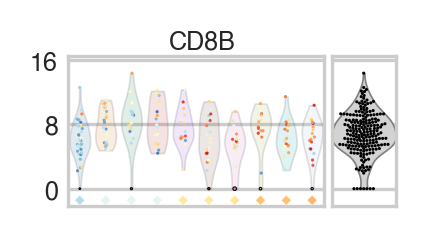

/Users/martinweissman/opt/miniconda3/envs/clonalomics/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 6.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


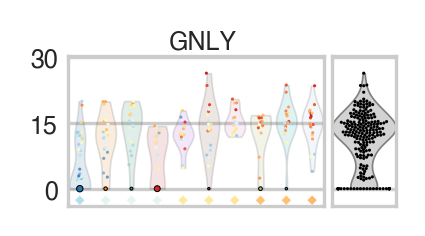

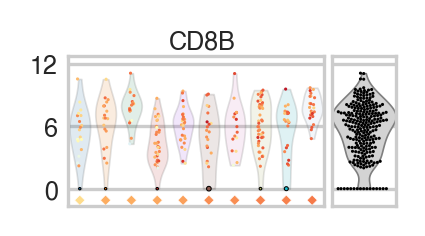

/Users/martinweissman/opt/miniconda3/envs/clonalomics/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 14.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


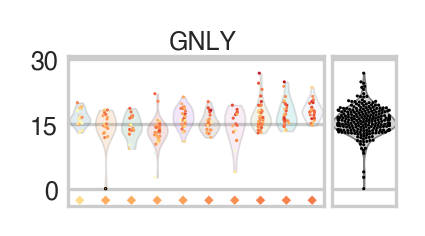

/Users/martinweissman/opt/miniconda3/envs/clonalomics/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 8.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


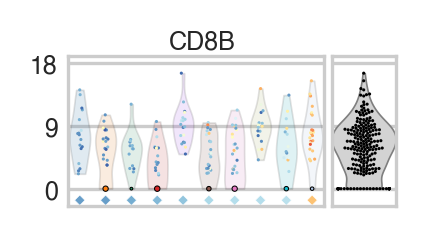

/Users/martinweissman/opt/miniconda3/envs/clonalomics/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 22.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


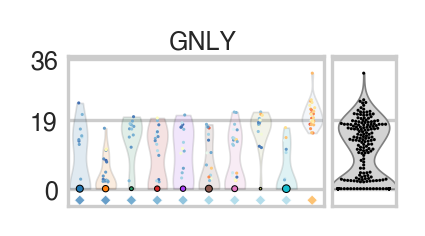

In [56]:
for ds in datasets[:3]:
    for gene in ['CD8B', 'GNLY']:
        minivio(gene, ads[ds], hide_clones=True, filename='Panels/Violins/{}_{}.pdf'.format(ds,gene))

# Little GNLY and celltype plot

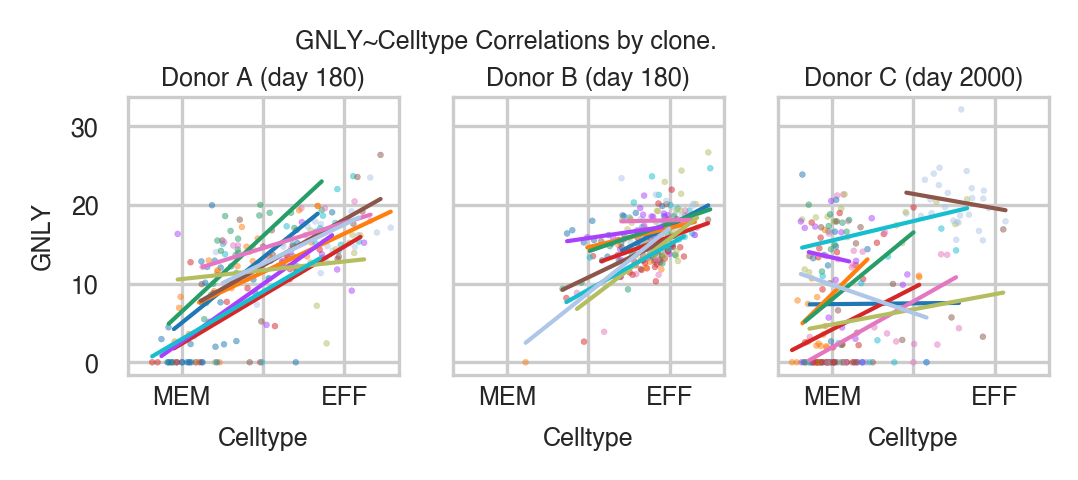

In [57]:
fig,ax = plt.subplots(1,3,figsize=(100*mm, 30*mm), dpi=300, sharey=True)
for j,ds in enumerate(datasets[:3]):
    plot_df = pd.DataFrame(ads[ds].to_df()['GNLY'])
    plot_df['Clone'] = ads[ds].obs.clone_id
    plot_df['Celltype'] = ads[ds].obs.Celltype
    sns.scatterplot(x='Celltype', y='GNLY', hue='Clone', s=2, alpha=0.5,
                    edgecolor=None, data=plot_df, ax=ax[j], legend=False)
    for clone in plot_df.Clone.unique():
        sns.regplot(x='Celltype', y='GNLY', scatter=False, ci=None, line_kws={'linewidth':1.0}, 
                    data=plot_df[plot_df.Clone == clone], ax=ax[j])
    ax[j].set_title(ds_titles[ds], y=0.95)
    ax[j].set_xlim(-0.5,0.5)
    ax[j].set_xticks([-0.3,0,0.3])
    ax[j].set_xticklabels(['MEM','','EFF'])
    ax[j].tick_params(axis='x', pad=-1)
plt.suptitle('GNLY~Celltype Correlations by clone.', y=1.1)

plt.show()

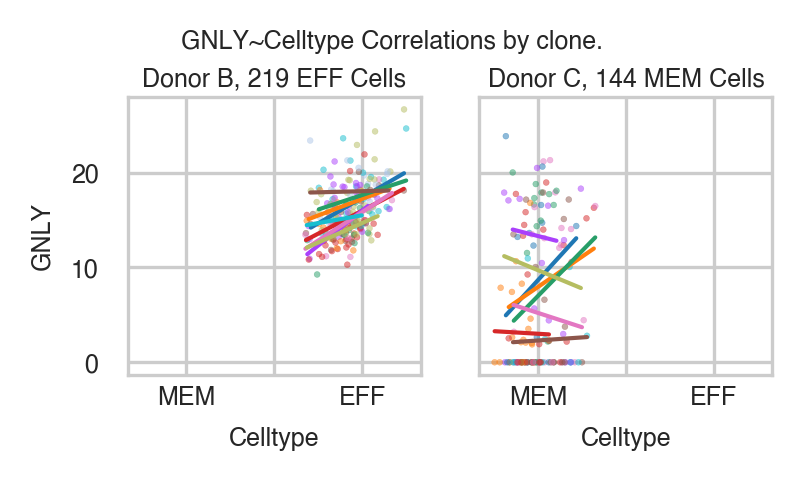

In [58]:
fig,ax = plt.subplots(1,2,figsize=(70*mm, 30*mm), dpi=300, sharey=True)
for j,ds in enumerate(datasets[3:]):
    plot_df = pd.DataFrame(ads[ds].to_df()['GNLY'])
    plot_df['Clone'] = ads[ds].obs.clone_id
    plot_df['Celltype'] = ads[ds].obs.Celltype
    sns.scatterplot(x='Celltype', y='GNLY', hue='Clone', s=2, alpha=0.5,
                    edgecolor=None, data=plot_df, ax=ax[j], legend=False)
    for clone in plot_df.Clone.unique():
        sns.regplot(x='Celltype', y='GNLY', scatter=False, ci=None, line_kws={'linewidth':1.0}, 
                    data=plot_df[plot_df.Clone == clone], ax=ax[j])
    ax[j].set_title(ds_titles[ds], y=0.95)
    ax[j].set_xlim(-0.5,0.5)
    ax[j].set_xticks([-0.3,0,0.3])
    ax[j].set_xticklabels(['MEM','','EFF'])
    ax[j].tick_params(axis='x', pad=-1)
plt.suptitle('GNLY~Celltype Correlations by clone.', y=1.1)

plt.show()

# Exploration of number of genes expressed

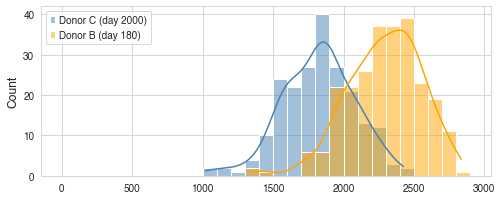

In [59]:
num_genes = {}
for ds in datasets:
    num_genes[ds] = (ads[ds].to_df() > 0).sum(axis=1)

desetfontsize()
fig,ax = plt.subplots(1,1,figsize=(8,3))
bins=np.arange(0,3000,100)
sns.histplot(num_genes[jh], label=ds_titles[jh], kde=True, bins=bins, color='steelblue', ax=ax)
sns.histplot(num_genes[a30], label=ds_titles[a30], kde=True, bins=bins, color='orange', ax=ax)

plt.legend()
plt.show()

In [60]:
ng_clonal = {}
for ds in datasets:
    ng_clonal[ds] = pd.DataFrame((ads[ds].to_df() > 0).groupby(ads[ds].obs.clone_id).max().sum(axis=1))
    ng_clonal[ds].columns = ['genes_per_clone']
    for j in range(100):    
        sh = 'Shuffle_{}'.format(j)
        ng_clonal[ds][sh] = (ads[ds].to_df() > 0).groupby(ads[ds].obs[sh]).max().sum(axis=1)
#desetfontsize()
#fig,ax = plt.subplots(1,1,figsize=(8,3))
#bins=np.arange(0,3000,100)
#sns.histplot(num_genes[jh], label=ds_titles[jh], kde=True, bins=bins, color='steelblue', ax=ax)
#sns.histplot(num_genes[a30], label=ds_titles[a30], kde=True, bins=bins, color='orange', ax=ax)

#plt.legend()
#plt.show()

In [61]:
for ds in datasets:
    ng_clonal[ds]['median'] = ng_clonal[ds].drop('genes_per_clone', axis=1).median(axis=1)

In [62]:
ng_clonal[a30][['genes_per_clone','median']]

,genes_per_clone,median
clone_id,,
B7,8060,8049.5
B24,8061,8052.0
B44,7989,7999.5
B66,8483,8508.5
B8,8340,8371.5
B102,8307,8275.5
B212,7804,7838.5
B39,8578,8590.0
B12,8320,8343.5


# Regression experiment

Here we look, gene by gene, at how much celltype explains variance.  Then we regress out celltype, and look at how much clonality explains variance.  First is an all-purpose ANOVA function.

Now we compute stuff... it will take a little while.

In [94]:
def quick_eta(gf, grouper):
    N = len(gf)
    groups = grouper.loc[gf.index].unique()
    K = len(groups)
    F_stats = f_oneway(*[gf[grouper == k] for k in groups])[0]
    # p_stats = f_oneway(*[gf[grouper == k] for k in groups])[1]
    F_times_df = F_stats * (K - 1)
    eta_sq = F_times_df / (F_times_df + (N-K))
    return pd.Series(eta_sq, index=gf.columns)
    

In [64]:
reg_df = {}
ad_reg = {}
for ds in datasets:
    X = ads[ds].to_df()
    y = ads[ds].obs.Celltype
    reg_df[ds] = pd.DataFrame(index = X.columns, columns=['rvalue'])
    print('Carrying out regression on {}...'.format(ds_titles[ds]))
    for gene in X.columns:
        LR = ss.linregress(y, X[gene])
        reg_df[ds].loc[gene,'rvalue'] = LR.rvalue
    reg_df[ds]['rsq'] = reg_df[ds]['rvalue']**2
    print('Regressing out celltype scores...')
    ad_reg[ds] = sc.pp.regress_out(ads[ds], 'Celltype', copy=True)

Carrying out regression on Donor A (day 180)...


... storing 'Donor' as categorical
... storing 'DonorDay' as categorical
... storing 'batch' as categorical
... storing 'phase' as categorical


Regressing out celltype scores...
Carrying out regression on Donor B (day 180)...
Regressing out celltype scores...


... storing 'Donor' as categorical
... storing 'DonorDay' as categorical
... storing 'batch' as categorical
... storing 'phase' as categorical


Carrying out regression on Donor C (day 2000)...


... storing 'Donor' as categorical
... storing 'DonorDay' as categorical
... storing 'batch' as categorical
... storing 'phase' as categorical


Regressing out celltype scores...
Carrying out regression on Donor B, 219 EFF Cells...


... storing 'Donor' as categorical
... storing 'DonorDay' as categorical
... storing 'batch' as categorical
... storing 'phase' as categorical


Regressing out celltype scores...
Carrying out regression on Donor C, 144 MEM Cells...
Regressing out celltype scores...


... storing 'Donor' as categorical
... storing 'DonorDay' as categorical
... storing 'batch' as categorical
... storing 'phase' as categorical


In [96]:
ETA_df = {}
for ds in datasets:
    X = ad_reg[ds].to_df()
    ETA_df[ds] = pd.DataFrame(index = X.columns)
    for col in ['clone_id'] + ['Shuffle_{}'.format(str(j)) for j in range(100)]:
        y = ad_reg[ds].obs[col]
        ETA_df[ds][col] = quick_eta(X,y)
    print('{} complete.'.format(ds_titles[ds]))
    hrule()

Donor A (day 180) complete.
Donor B (day 180) complete.
Donor C (day 2000) complete.
Donor B, 219 EFF Cells complete.
Donor C, 144 MEM Cells complete.


In [97]:
eta_cut = {}
for ds in datasets:
    eta_cut[ds] = ETA_df[ds].drop('clone_id',axis=1).quantile(1 - 1/len(ETA_df[ds])).median()
    eta_cut[ds] = np.round(eta_cut[ds], 2)
    print(ds, eta_cut[ds])

A1_06_D180 0.16
A1_30_D180 0.13
JH_D2000 0.16
EFF 0.14
MEM 0.2


In [98]:
plot_df = {}
for ds in datasets:
    plot_df[ds] = pd.DataFrame(index=ETA_df[ds].index)
    plot_df[ds]['Clonal impact on variance'] = ETA_df[ds]['clone_id']
    plot_df[ds]['Celltype impact on variance'] = reg_df[ds]['rsq']
plot_df[ds]

,Clonal impact on variance,Celltype impact on variance
gene_name,,
WASH7P,0.037028,0.000001
MTND1P23,0.053315,0.000526
MTND2P28,0.056724,0.003206
hsa-mir-6723,0.033673,0.000272
RP5-857K21.7,0.037512,0.005825
...,...,...
F8A2-1,0.112345,0.006285
TMLHE-1,0.053652,0.005666
VAMP7,0.050116,0.000003


In [99]:
from adjustText import adjust_text

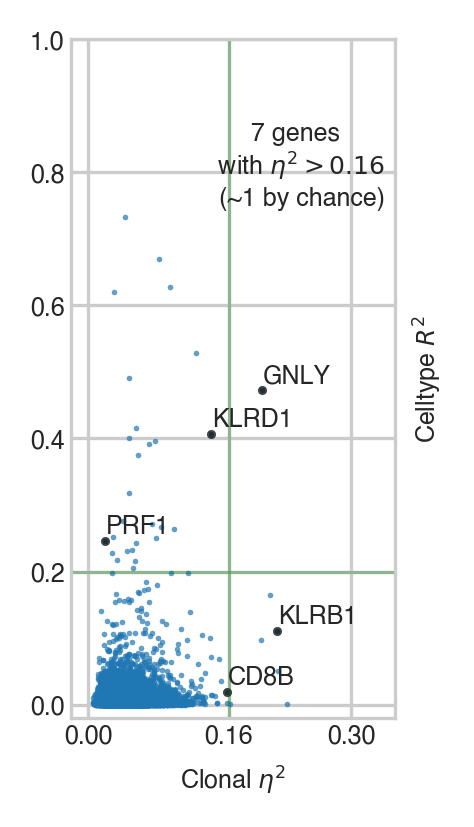

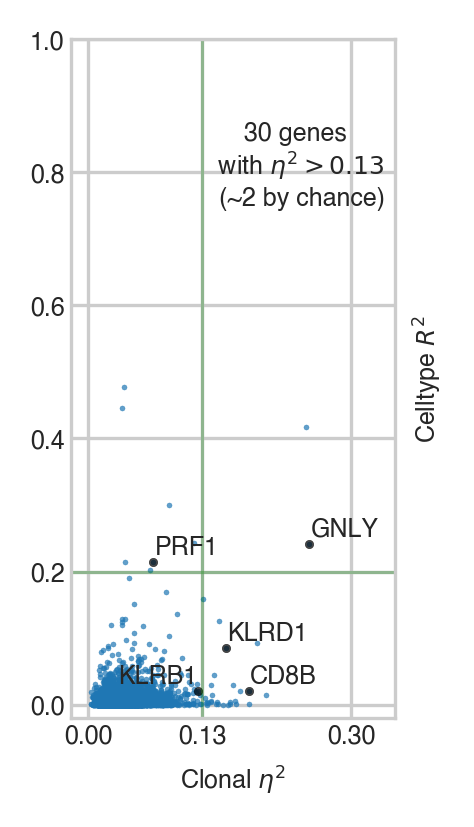

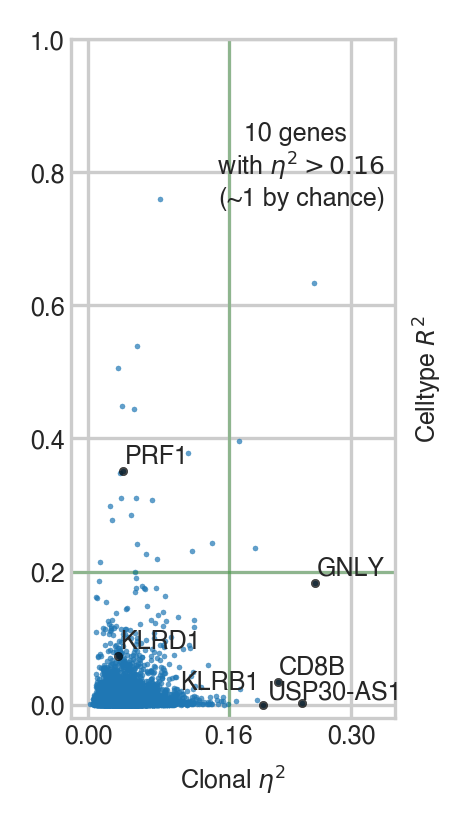

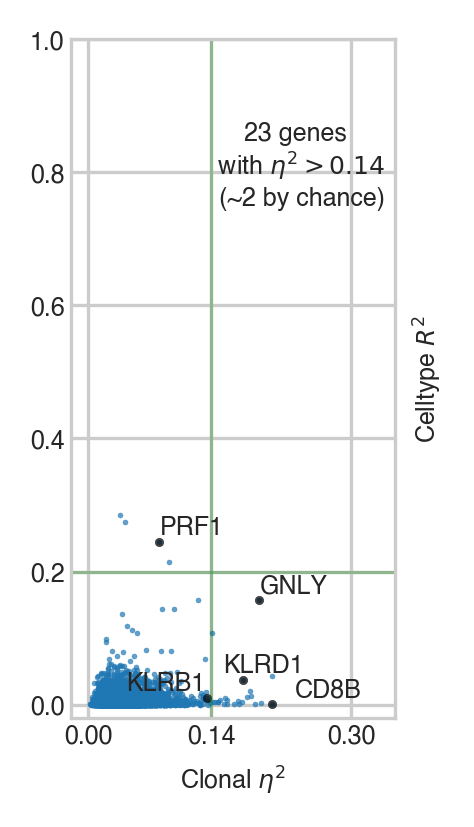

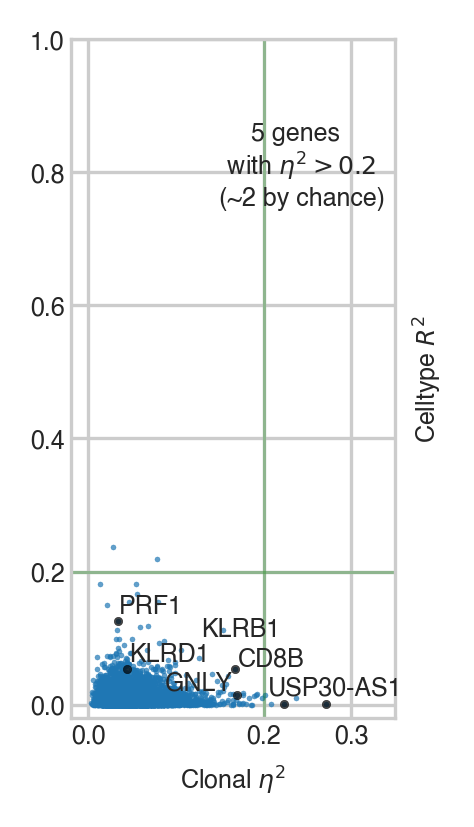

In [104]:
genes_focus = ['CD8B','GNLY','KLRD1','KLRB1','PRF1','USP30-AS1']
        
for ds in datasets:
    sns.set_style('whitegrid')
    setfontsize()
    
    figsize=(40*mm,70*mm)
    fig,ax = plt.subplots(figsize=figsize, dpi=300)
    
    ax.tick_params(axis='both', which='major', pad=-2)

    sns.scatterplot(y='Celltype impact on variance', x = 'Clonal impact on variance', 
                    data=plot_df[ds], edgecolor=None, s=1.5, alpha=0.7, legend=False)
    plt.xlim(-0.02,0.35)
    plt.ylim(-0.02,1.0)
    
    ax.set_yticks([0,0.2,0.4,0.6,0.8,1.0])
    ax.set_xticks([0,eta_cut[ds],0.3])

    y_series = plot_df[ds]['Celltype impact on variance']
    x_series = plot_df[ds]['Clonal impact on variance']

    genes_plot = [gene for gene in genes_focus if gene in plot_df[ds].index]
    
    texts = [plt.text(x_series[gene], y_series[gene], gene, ha='center', va='center') for gene in genes_plot]

    adjust_text(texts, expand_text=(1.02, 1.00))
    
    sns.scatterplot(y='Celltype impact on variance', x = 'Clonal impact on variance',  
                    data=plot_df[ds].loc[genes_plot], edgecolor='k', s=4.0, alpha=0.7, color='k')

    ax.axvline(eta_cut[ds], color='green', linewidth=0.75, alpha=0.3)
    ax.axhline(0.2, color='green', linewidth=0.75, alpha=0.3)
    
    by_chance = (ETA_df[ds].drop('clone_id', axis=1) > eta_cut[ds]).sum().median()
    clonal_signal = (ETA_df[ds]['clone_id'] > eta_cut[ds]).sum()
    
    ax.text(0.24, 0.75,
            '{} genes \n with $\eta^2 > {}$ \n (~{} by chance)'.format(clonal_signal, eta_cut[ds], int(by_chance)),
           ha = 'center')
    ax.set_ylabel('Celltype $R^2$')
    ax.yaxis.set_label_position("right")
    ax.set_xlabel('Clonal $\eta^2$')
    #plt.suptitle('Clonal and celltype contributions to variance', y=0.97)
    set_size(fig, figsize)
    plt.savefig('Clonal_Celltype_Gene_Variances/{}_CC_Variance.pdf'.format(ds), bbox_inches='tight')
    
    plt.show()


In [114]:
eta_genes = {}
for ds in datasets:
    eta_sq = ETA_df[ds]['clone_id']
    eta_genes[ds] = eta_sq[eta_sq > eta_cut[ds]].copy().sort_values(ascending=False)
    eta_genes[ds].name = 'Clonal_eta_squared'
    display(eta_genes)
    eta_genes[ds].to_csv('eta_genes_'+ds+'.csv')
    

{'A1_06_D180': gene_name
 PAX8-AS1       0.227043
 C1orf228       0.215879
 KLRB1          0.215296
 CD300A         0.207356
 GNLY           0.197850
 KCNN4          0.197497
 KLRC4-KLRK1    0.161691
 Name: Clonal_eta_squared, dtype: float64}

{'A1_06_D180': gene_name
 PAX8-AS1       0.227043
 C1orf228       0.215879
 KLRB1          0.215296
 CD300A         0.207356
 GNLY           0.197850
 KCNN4          0.197497
 KLRC4-KLRK1    0.161691
 Name: Clonal_eta_squared, dtype: float64,
 'A1_30_D180': gene_name
 GNLY            0.252283
 GZMH            0.247824
 AMICA1          0.202601
 ZNF683          0.192834
 GFPT2           0.183348
 CD8B            0.182904
 ITGB1           0.172805
 ITM2A           0.168032
 NCAPG2          0.167677
 HLA-DRB1        0.164737
 CD5             0.161937
 NSG1            0.161096
 MT-ND5          0.159485
 KLRD1           0.156918
 CACNA2D4        0.153996
 IL7R            0.149127
 C1orf162        0.147763
 HAVCR2          0.147235
 DDX10           0.145934
 DFNB31          0.143074
 TTPAL           0.140517
 HOPX            0.140403
 ALOX5AP         0.139660
 RP11-23P13.6    0.139541
 CD160           0.136826
 SLC35B4         0.135271
 KLRG1           0.134774
 GRK5            0.133742
 MAT

{'A1_06_D180': gene_name
 PAX8-AS1       0.227043
 C1orf228       0.215879
 KLRB1          0.215296
 CD300A         0.207356
 GNLY           0.197850
 KCNN4          0.197497
 KLRC4-KLRK1    0.161691
 Name: Clonal_eta_squared, dtype: float64,
 'A1_30_D180': gene_name
 GNLY            0.252283
 GZMH            0.247824
 AMICA1          0.202601
 ZNF683          0.192834
 GFPT2           0.183348
 CD8B            0.182904
 ITGB1           0.172805
 ITM2A           0.168032
 NCAPG2          0.167677
 HLA-DRB1        0.164737
 CD5             0.161937
 NSG1            0.161096
 MT-ND5          0.159485
 KLRD1           0.156918
 CACNA2D4        0.153996
 IL7R            0.149127
 C1orf162        0.147763
 HAVCR2          0.147235
 DDX10           0.145934
 DFNB31          0.143074
 TTPAL           0.140517
 HOPX            0.140403
 ALOX5AP         0.139660
 RP11-23P13.6    0.139541
 CD160           0.136826
 SLC35B4         0.135271
 KLRG1           0.134774
 GRK5            0.133742
 MAT

{'A1_06_D180': gene_name
 PAX8-AS1       0.227043
 C1orf228       0.215879
 KLRB1          0.215296
 CD300A         0.207356
 GNLY           0.197850
 KCNN4          0.197497
 KLRC4-KLRK1    0.161691
 Name: Clonal_eta_squared, dtype: float64,
 'A1_30_D180': gene_name
 GNLY            0.252283
 GZMH            0.247824
 AMICA1          0.202601
 ZNF683          0.192834
 GFPT2           0.183348
 CD8B            0.182904
 ITGB1           0.172805
 ITM2A           0.168032
 NCAPG2          0.167677
 HLA-DRB1        0.164737
 CD5             0.161937
 NSG1            0.161096
 MT-ND5          0.159485
 KLRD1           0.156918
 CACNA2D4        0.153996
 IL7R            0.149127
 C1orf162        0.147763
 HAVCR2          0.147235
 DDX10           0.145934
 DFNB31          0.143074
 TTPAL           0.140517
 HOPX            0.140403
 ALOX5AP         0.139660
 RP11-23P13.6    0.139541
 CD160           0.136826
 SLC35B4         0.135271
 KLRG1           0.134774
 GRK5            0.133742
 MAT

{'A1_06_D180': gene_name
 PAX8-AS1       0.227043
 C1orf228       0.215879
 KLRB1          0.215296
 CD300A         0.207356
 GNLY           0.197850
 KCNN4          0.197497
 KLRC4-KLRK1    0.161691
 Name: Clonal_eta_squared, dtype: float64,
 'A1_30_D180': gene_name
 GNLY            0.252283
 GZMH            0.247824
 AMICA1          0.202601
 ZNF683          0.192834
 GFPT2           0.183348
 CD8B            0.182904
 ITGB1           0.172805
 ITM2A           0.168032
 NCAPG2          0.167677
 HLA-DRB1        0.164737
 CD5             0.161937
 NSG1            0.161096
 MT-ND5          0.159485
 KLRD1           0.156918
 CACNA2D4        0.153996
 IL7R            0.149127
 C1orf162        0.147763
 HAVCR2          0.147235
 DDX10           0.145934
 DFNB31          0.143074
 TTPAL           0.140517
 HOPX            0.140403
 ALOX5AP         0.139660
 RP11-23P13.6    0.139541
 CD160           0.136826
 SLC35B4         0.135271
 KLRG1           0.134774
 GRK5            0.133742
 MAT

In [119]:
for ds in datasets:
    print(sig_genes[ds])
    hrule(length=10)
    print(eta_genes[ds].index)
    print([gene for gene in eta_genes[ds].index if gene not in sig_genes[ds]])
    hrule()

['AOAH', 'C1orf228', 'CCL4', 'CCR7', 'CD300A', 'COL18A1', 'CST7', 'FCGR3A', 'FCRL6', 'FGFBP2', 'FOS', 'GNLY', 'GPR56', 'GZMB', 'GZMH', 'GZMK', 'IFNG-AS1', 'IL7R', 'ITGAM', 'KCNN4', 'KLRB1', 'KLRD1', 'LDHB', 'LTB', 'NKG7', 'NOSIP', 'PAX8-AS1', 'RHOH', 'RP11-23P13.6', 'S1PR5', 'SELL', 'TCF7']
Index(['PAX8-AS1', 'C1orf228', 'KLRB1', 'CD300A', 'GNLY', 'KCNN4',
       'KLRC4-KLRK1'],
      dtype='object', name='gene_name')
['KLRC4-KLRK1']
['ALOX5AP', 'AMICA1', 'C1orf162', 'CACNA2D4', 'CD28', 'CD300A', 'CD5', 'CD8B', 'DDX10', 'DFNB31', 'FCGR3A', 'GFPT2', 'GNLY', 'GPR56', 'GZMH', 'HAVCR2', 'HLA-DRB1', 'HLA-DRB5', 'HOPX', 'IL7R', 'ITGB1', 'ITM2A', 'KLRD1', 'KLRG1', 'MT-ND5', 'NCAPG2', 'NKG7', 'NSG1', 'RNVU1-19', 'RP11-23P13.6', 'SATB1', 'SPON2', 'TSPYL2-1', 'TTPAL', 'ZNF683']
Index(['GNLY', 'GZMH', 'AMICA1', 'ZNF683', 'GFPT2', 'CD8B', 'ITGB1', 'ITM2A',
       'NCAPG2', 'HLA-DRB1', 'CD5', 'NSG1', 'MT-ND5', 'KLRD1', 'CACNA2D4',
       'IL7R', 'C1orf162', 'HAVCR2', 'DDX10', 'DFNB31', 'TTPAL', 'HO

# Matched celltype fake clones

In [290]:
adata[jh]

AnnData object with n_obs × n_vars = 1201 × 8015
    obs: 'Celltype', 'Donor', 'DonorDay', 'G2M_score', 'S_score', 'Timepoint', 'batch', 'clone_id', 'is_clone0', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_mt', 'n_counts', 'n_genes', 'n_genes_by_counts', 'obs_names', 'pct_counts_mt', 'phase', 'total_counts', 'total_counts_mt'
    var: 'Celltype_load', 'GC_content', 'gene_name', 'highly_variable', 'highly_variable_rank', 'log1p_mean_counts', 'log1p_total_counts', 'mean_counts', 'means', 'mt', 'n_cells', 'n_cells_by_counts', 'n_counts', 'pct_dropout_by_counts', 'total_counts', 'transcript_length', 'variances', 'variances_norm'

In [301]:
np.random.choice([-2,5,7])

7

In [291]:
bigclones[jh]

['C35', 'C107', 'C154', 'C27', 'C87', 'C75', 'C29', 'C67', 'C25', 'C38']

In [334]:
def make_matched_clone(ad, clone):
    ct_series = ad.obs.Celltype.sort_values()
    ct_order = pd.Series(range(len(ct_series)), index=ct_series.index)
    cl_cells = list(ad[ad.obs.clone_id == clone, :].obs_names)
    newcells = cl_cells[:] # Make copy.
    print(len(cl_cells), len(newcells))
    for j,cell in enumerate(cl_cells):
        #print(cell, ct_order[cell], ct_series[cell])
        newcell_num = ct_order[cell] + 1 #np.random.choice([-1,1])
        newcells[j] = ct_series.index[newcell_num]
    #display(ct_series.loc[cl_cells])
    #display(ct_series.loc[newcells])
    return newcells

In [335]:
adata[jh].obs['FakeClone'] = ''
for cl in bigclones[jh]:
    new_clone = make_matched_clone(adata[jh], cl)
    #print(len(new_clone))
    adata[jh].obs.loc[new_clone,'FakeClone'] = cl+'_fake'

30 30
26 26
26 26
26 26
21 21
18 18
17 17
16 16
16 16
14 14


In [336]:
adata[jh].obs['FakeClone'].value_counts()

             991
C35_fake      30
C27_fake      26
C154_fake     26
C107_fake     26
C87_fake      21
C75_fake      18
C29_fake      17
C67_fake      16
C25_fake      16
C38_fake      14
Name: FakeClone, dtype: int64

In [337]:
ad_fake = adata[jh][adata[jh].obs['FakeClone'] != '', :]
ad_fake

View of AnnData object with n_obs × n_vars = 210 × 8015
    obs: 'Celltype', 'Donor', 'DonorDay', 'G2M_score', 'S_score', 'Timepoint', 'batch', 'clone_id', 'is_clone0', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_mt', 'n_counts', 'n_genes', 'n_genes_by_counts', 'obs_names', 'pct_counts_mt', 'phase', 'total_counts', 'total_counts_mt', 'FakeClone'
    var: 'Celltype_load', 'GC_content', 'gene_name', 'highly_variable', 'highly_variable_rank', 'log1p_mean_counts', 'log1p_total_counts', 'mean_counts', 'means', 'mt', 'n_cells', 'n_cells_by_counts', 'n_counts', 'pct_dropout_by_counts', 'total_counts', 'transcript_length', 'variances', 'variances_norm'

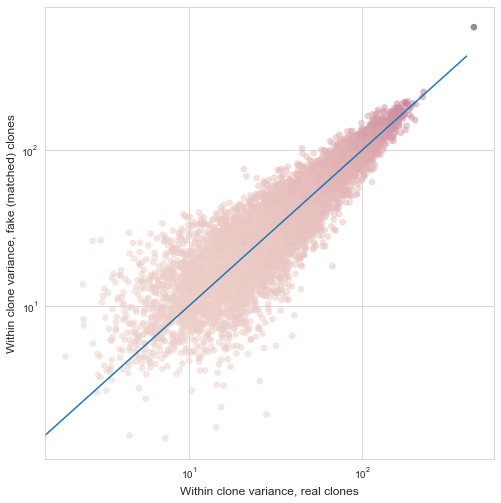

In [357]:
plot_df = pd.DataFrame(index=ads[jh].to_df().columns)
plot_df['Real'] = ads[jh].to_df().groupby(ads[jh].obs.clone_id).var().sum()
plot_df['Fake'] = ad_fake.to_df().groupby(ad_fake.obs.FakeClone).var().sum()
plot_df['Var'] = adata[jh].to_df().var()
desetfontsize()
fig,ax = plt.subplots(1,1,figsize=(8,8))

sns.scatterplot(x='Real', y='Fake', hue='Var', data=plot_df, legend=False, edgecolor=None, alpha=0.5)
ax.set_xlabel('Within clone variance, real clones')
ax.set_ylabel('Within clone variance, fake (matched) clones')
plt.plot([0,400], [0,400])
plt.xscale('log')
plt.yscale('log')
plt.show()

In [354]:
(plot_df['Real'] < plot_df['Fake']).sum()

4369

In [356]:
p_sig[jh]

gene_name
GZMB           1.177240e-37
FCGR3A         1.557921e-28
GZMH           6.275643e-27
TIGIT          5.050347e-24
ZNF683         1.712470e-20
GNLY           4.397361e-19
FCGR3B         1.236872e-17
NKG7           3.058785e-11
GZMK           1.265223e-10
PRF1           1.737040e-10
FGR            3.006519e-10
F2R            3.201310e-10
IL7R           5.932640e-10
ITGAL          6.078623e-10
LTB            1.554091e-09
USP30-AS1      3.778885e-09
CD63           9.834051e-09
FGFBP2         1.393249e-08
BZRAP1         1.568995e-08
GPR56          2.997881e-08
CD8B           3.818393e-08
FCRL6          4.721004e-08
AOAH           4.897383e-08
FAM211A-AS1    5.548059e-08
DGKA           8.060724e-08
COL6A2         8.574948e-08
IL2RB          1.520536e-07
CTSW           1.884879e-07
RPLP0          3.338962e-07
RPLP0P6        5.690024e-07
TMSB4XP8       6.984875e-07
STOM           7.259477e-07
KLRB1          8.749445e-07
PRSS21         1.045578e-06
FCRL3          1.056023e-06
ANXA2     

gene_name
WASH7P          79.370796
MTND1P23        22.666023
MTND2P28        65.243332
hsa-mir-6723    52.728287
RP5-857K21.7    25.966845
                  ...    
F8A2-1          16.560982
TMLHE-1         32.585720
VAMP7           44.468815
RNA5-8SP6       45.735569
PSMA6P1          9.476218
Length: 8015, dtype: float32

# Little clonal clustering experiment

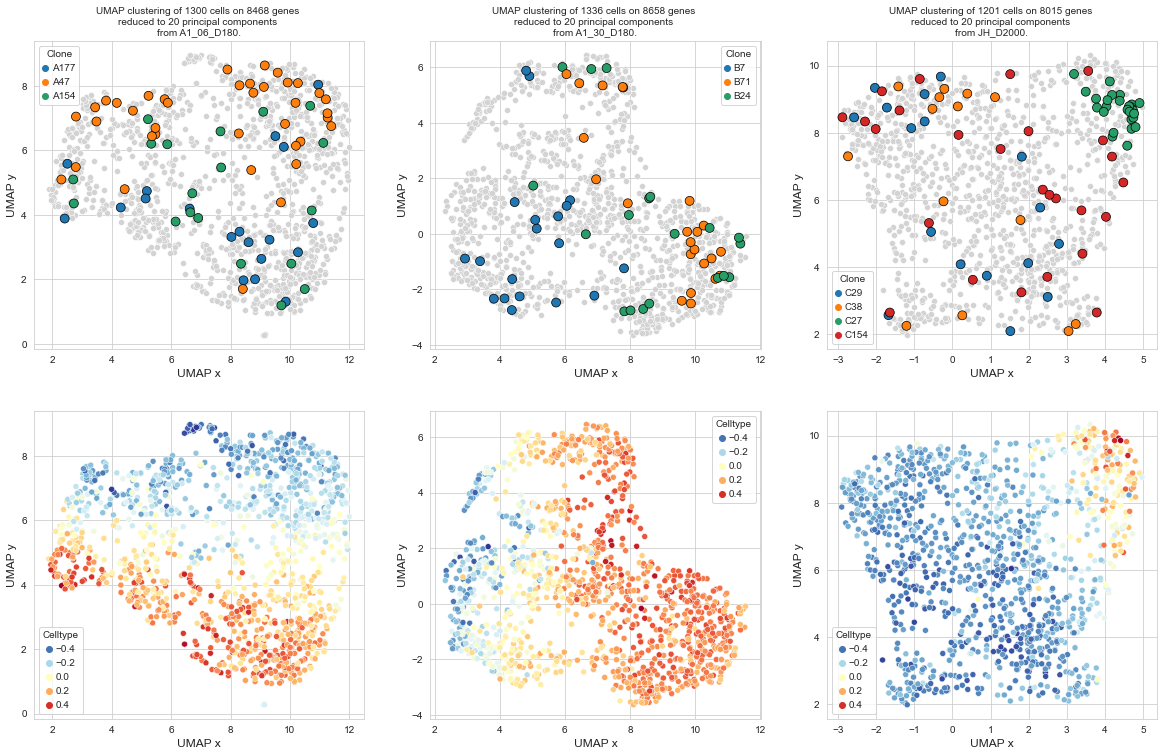

In [813]:
n_components = 20
n_neighbors = 10
min_dist = 0.25
fig, ax = plt.subplots(2,3, figsize=(20,12))
desetfontsize()

for j,ds in enumerate(datasets):
    X = adata[ds].to_df()
    y = adata[ds].obs.clone_id
    z = adata[ds].obs.Celltype
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X) # Apply PCA with 20 components.
    X_embedded = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, 
                           random_state = 42, metric='cosine').fit_transform(X_pca) # Reduce from 10 components to 2-dimensions.

    cl_df = pd.DataFrame(X_embedded, columns = ['UMAP x', 'UMAP y'], index=X.index) # Just for graphing.
    cl_df['Clone'] = y.values
    cl_df['Celltype'] = z.values
    cl_df['Clone'] = cl_df['Clone'].map({'C29':'C29', 'C27':'C27', 'C154':'C154', 'C38':'C38',
                                        'A47':'A47', 'A177':'A177', 'A154':'A154',
                                         'B71':'B71', 'B7':'B7','B24':'B24'}).fillna('Other')
    g = sns.scatterplot(x='UMAP x', y='UMAP y', data = cl_df[cl_df['Clone'] == 'Other'], color='lightgray',
                        ax=ax[0,j])
    g = sns.scatterplot(x='UMAP x', y='UMAP y', hue='Clone', data = cl_df[cl_df['Clone'] != 'Other'], 
                        edgecolor='k', ax=ax[0,j], s=80)
    g = sns.scatterplot(x='UMAP x', y='UMAP y', hue='Celltype', palette='RdYlBu_r', hue_norm=(-0.5,0.5), 
                        data = cl_df, ax=ax[1,j])
    
    #if j == 0:
    #    g.legend(loc='center left', bbox_to_anchor=(-0.55, 0.5), ncol=1)

    ax[0,j].set_title('UMAP clustering of {} cells on {} genes \n' 
                    'reduced to {} principal components \n'
                    'from {}.'.format(X.shape[0], X.shape[1], n_components, ds))

plt.show()

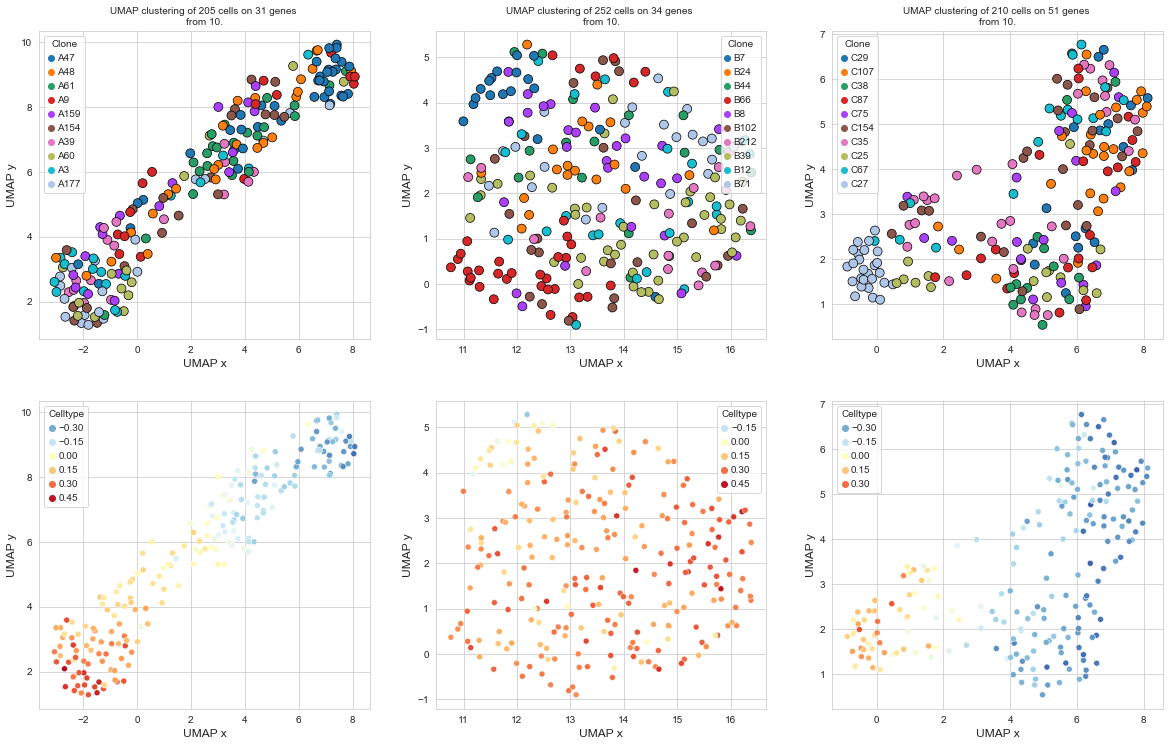

In [819]:
n_components = 10
n_neighbors = 10
min_dist = 0.25
fig, ax = plt.subplots(2,3, figsize=(20,12))
desetfontsize()

for j,ds in enumerate(datasets):
    X = ads[ds].to_df()
    X = X[sig_genes[ds]]
    y = ads[ds].obs.clone_id
    z = ads[ds].obs.Celltype
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X) # Apply PCA with 20 components.
    X_embedded = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, 
                           random_state = 42, metric='cosine').fit_transform(X) # Reduce from 10 components to 2-dimensions.

    cl_df = pd.DataFrame(X_embedded, columns = ['UMAP x', 'UMAP y'], index=X.index) # Just for graphing.
    cl_df['Clone'] = y.values
    cl_df['Celltype'] = z.values
    #cl_df['Clone'] = cl_df['Clone'].map({'C29':'C29', 'C27':'C27', 'C154':'C154', 'C38':'C38',
    #                                    'A47':'A47', 'A177':'A177', 'A154':'A154',
    #                                     'B71':'B71', 'B7':'B7','B24':'B24'}).fillna('Other')
    #g = sns.scatterplot(x='UMAP x', y='UMAP y', data = cl_df[cl_df['Clone'] == 'Other'], color='lightgray',
    #                    ax=ax[0,j])
    g = sns.scatterplot(x='UMAP x', y='UMAP y', hue='Clone', data = cl_df[cl_df['Clone'] != 'Other'], 
                        edgecolor='k', ax=ax[0,j], s=80)
    g = sns.scatterplot(x='UMAP x', y='UMAP y', hue='Celltype', palette='RdYlBu_r', hue_norm=(-0.5,0.5), 
                        data = cl_df, ax=ax[1,j])
    
    #if j == 0:
    #    g.legend(loc='center left', bbox_to_anchor=(-0.55, 0.5), ncol=1)

    ax[0,j].set_title('UMAP clustering of {} cells on {} genes \n' 
                    'from {}.'.format(X.shape[0], X.shape[1], n_components, ds))

plt.show()

# SVM Quickshot

In [436]:
def CV_map(gs, swap=False, savefig=False):  # parameter_grid and grid_search.
    '''
    A general-purpose visualization for grid-search cross-validations.
    Displays predictive accuracy as a heatmap, based on different
    choices of parameters.  Displays optimal parameters in title.
    
    Args:
        gs (sklearn.model_selection.GridSearchCV):  The grid-search object.
        swap:  Set to True to switch the axes.
        
    Returns:
        None
        
    '''
    results = gs.cv_results_
    means = results['mean_test_score']
    params = list(gs.param_grid.keys())
    
    ser = pd.Series(list(means),
                  index=pd.MultiIndex.from_tuples(
                      [tuple(d.values()) for d in results['params']])
               )
    gs_df = ser.unstack().fillna(0)
    gs_df.shape 
    if swap:
        gs_df = gs_df.transpose()
        params = params[::-1] # Switch the order of the parameter list.
    
    f, ax = plt.subplots(figsize=(12,12))
    sns.heatmap(gs_df, annot=True, square=True, fmt="2.0%", linewidths=.5, 
                cbar_kws={'fraction':0.025, 'pad':0.05}, ax=ax)
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([.5, .6, .7, .8, .9])
    cbar.set_ticklabels(['50%', '60%', '70%', '80%', '90%'])
    ax.set_xlabel(params[1])
    ax.set_ylabel(params[0])
    plt.yticks(rotation=0)
    bestacc = gs.best_score_
    ax.set_title("Result of grid-search with 5-fold cross-validation. \n"
                 "Best score {0:2.1%} with parameters \n"
                 "{1} ".format(gs.best_score_, gs.best_params_))
    if savefig:
        plt.savefig('CV_map.svg')

In [437]:
def confusion_matrix(X,y,pipe, reps=2, classlist = None, filename=None):
    if classlist:
        classes = classlist
    else:
        classes = sorted(y.unique())
    counts = pd.DataFrame(0, index=classes, columns=classes)
    cpops = pd.DataFrame(0, index=classes, columns=['pop'])
    correct = 0
    total = 0
    for t in range(reps):
        this_pipe = base.clone(pipe)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        this_pipe.fit(X_train, y_train)
        y_pred = this_pipe.predict(X_test)
        actual = y_test
        predicted = y_pred
        for j in range(len(y_test)):
            total += 1
            if y_test[j] == y_pred[j]:
                correct += 1
            cpops.loc[y_test[j],'pop'] += 1
            counts.loc[y_test[j], y_pred[j]] += 1
    
    valid = counts.apply(lambda column : column/cpops['pop']) #['pop'] )
    valid_dec = (valid*100).astype(int)
    
    #f, ax = plt.subplots(figsize=(8,7))
    f, ax = plt.subplots(figsize=(1.2,1.25), dpi=300)
    setfontsize()
    #fmt="2.0%"
    sns.heatmap(valid, annot=valid_dec, annot_kws={'fontsize':5}, fmt="d", square=True, linewidths=.25, cbar=None,
                cbar_kws={'fraction':0.02, 'pad':0.02}, ax=ax)
    #cbar = ax.collections[0].colorbar
    #cbar.set_ticks([0, .25, .5, .75, 1])
    #cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
    ax.set_xticks([])
    ax.set_yticks([])
    tickypos = -0.3
    pal = sns.color_palette()
    lut = dict(zip(classes, pal))
    for j,cl in enumerate(classes):
        ax.add_patch(Rectangle((tickypos,j+0.1),0.3,0.8, color=lut[cl],fill=True,clip_on=False))
        ax.add_patch(Rectangle((j+0.1,tickypos),0.8,0.3, color=lut[cl],fill=True,clip_on=False))
        ax.add_patch(Rectangle((len(classes)-tickypos,j+0.1),-0.3,0.8, color=lut[cl],fill=True,clip_on=False))
        ax.add_patch(Rectangle((j+0.1,len(classes)-tickypos),0.8,-0.3, color=lut[cl],fill=True,clip_on=False))
    ax.set_ylabel("Actual clone")
    ax.set_xlabel("Predicted clone")
    ax.set_title("Predicted clonality (%).".format(correct / total))
    
    if filename:
        set_size(f, (1.2, 1.25))
        plt.savefig(filename, bbox_inches='tight')
    # "{} trials, in {} batches with independent splits.".format(correct/total, total, reps))

In [438]:
def sort_by(df, col, valuelist):
    '''
    Sorts a data frame, according to the values in a column,
    and a chosen order for these values.
    '''
    if set(df[col].unique()) != set(valuelist):
        print('Warning, cannot sort!')
        return df
    value_dict = {valuelist[j]:j for j in range(len(valuelist))}
    df['newcol'] = df[col].apply(lambda v : value_dict[v])
    df.sort_values('newcol', inplace=True)
    df.drop('newcol', axis=1)
    return df

In [439]:
def downsample(X,y):
    ymin = y.value_counts().min()
    sample = []
    for cl in y.unique():
        cells_cl = y[y == cl].index
        sample_cl = np.random.choice(cells_cl, ymin, replace=False)
        sample = sample + list(sample_cl)
    return X.loc[sample], y.loc[sample]
        

In [457]:
X = ads[a6].to_df().copy()
y = ads[a6].obs.clone_id.copy()

X,y = downsample(X,y)

In [458]:
y.value_counts()

A47     15
A48     15
A61     15
A9      15
A159    15
A154    15
A39     15
A60     15
A3      15
A177    15
Name: clone_id, dtype: int64

In [459]:
#  DANGER DANGER!  The lines below ignore all warnings.
#  It's nice to avoid all the convergence warnings.  
#  But dangerous in general.
import warnings
warnings.filterwarnings("ignore")
#  End of warning.... proceed below.

SVM_pipe = Pipeline([ ('mm', MinMaxScaler()),
                     ('skb', SelectKBest(score_func = f_classif, k=110)),
                     ('svm', LinearSVC(random_state=0, tol=1e-4, C=1.0, max_iter=2000)) ])

param_grid = dict(skb__k = [2,5,10,25,50,100,150,200,250,300], svm__C = [0.001, 0.01, 0.1, 1.0, 10.0])

grid_search = GridSearchCV(SVM_pipe, param_grid=param_grid, cv=5) #5-fold cross-validation.
grid_search.fit(X,y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('mm', MinMaxScaler()),
                                       ('skb', SelectKBest(k=110)),
                                       ('svm',
                                        LinearSVC(max_iter=2000,
                                                  random_state=0))]),
             param_grid={'skb__k': [2, 5, 10, 25, 50, 100, 150, 200, 250, 300],
                         'svm__C': [0.001, 0.01, 0.1, 1.0, 10.0]})

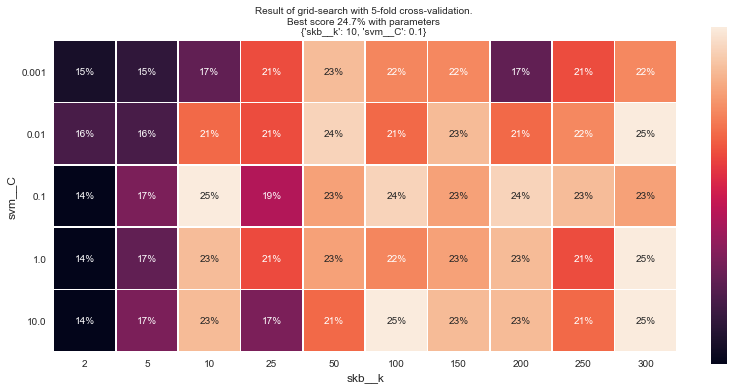

In [460]:
desetfontsize()
CV_map(grid_search, swap=True)

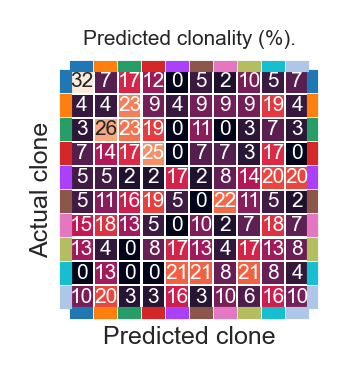

In [461]:
opt_k = grid_search.best_params_['skb__k'] # Use optimal number of genes.
opt_C = grid_search.best_params_['svm__C'] # Use optimal C-parameter for linear SVM.

SVMpipe = make_pipeline(MinMaxScaler(), 
                        SelectKBest(score_func = f_classif, k=opt_k), 
                        LinearSVC(random_state=0, tol=1e-4, max_iter = 2000, C=opt_C))

setfontsize()
classlist = list(clonetype[a6].categories)
confusion_matrix(X,y,SVMpipe, reps=10, classlist = classlist, filename='Panels/Confusion.pdf')